#  Case Study Flow - The Red Thread

##  Step 1 - Discover the Pattern of Success

Objective(s):
- to identify why some employees achieve rating 5 while others don’t.
- to perform data exploration and visualization (heatmaps, radar charts, correlation plots, comparison matrices) to uncover explain the why and what differentiates high performers across: `Competency pillars (competencies_yearly + dim_competency_pillars)`, `Psychometric profiles (papi_scores, profiles_psych)`, `Behavioral data (strengths)`, `Contextual factors (grade, years_of_service_months, education, etc.)`.
- synthesize those findings into a Success Formula, a weighted structure that captures how performance emerges from multiple factors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.impute import KNNImputer, SimpleImputer

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [2]:
FILE_PATH = "Study Case DA.xlsx"

dataset = pd.ExcelFile(FILE_PATH)
print('Sheets: ', dataset.sheet_names)

Sheets:  ['Talent Variable (TV) & Talent G', 'dim_companies', 'dim_areas', 'dim_positions', 'dim_departments', 'dim_divisions', 'dim_directorates', 'dim_grades', 'dim_education', 'dim_majors', 'dim_competency_pillars', 'employees', 'profiles_psych', 'papi_scores', 'strengths', 'performance_yearly', 'competencies_yearly']


In [3]:
employees_df = pd.read_excel(dataset, 'employees')
profiles_psych_df = pd.read_excel(dataset, 'profiles_psych')
papi_scores_df = pd.read_excel(dataset, 'papi_scores')
strengths_df = pd.read_excel(dataset, 'strengths')
performance_df = pd.read_excel(dataset, 'performance_yearly')
competencies_df = pd.read_excel(dataset, 'competencies_yearly')

In [4]:
dim_companies_df = pd.read_excel(dataset, 'dim_companies')
dim_areas_df = pd.read_excel(dataset, 'dim_areas')
dim_positions_df = pd.read_excel(dataset, 'dim_positions')
dim_departments_df = pd.read_excel(dataset, 'dim_departments')
dim_divisions_df = pd.read_excel(dataset, 'dim_divisions')
dim_directorates_df = pd.read_excel(dataset, 'dim_directorates')
dim_grades_df = pd.read_excel(dataset, 'dim_grades')
dim_education_df = pd.read_excel(dataset, 'dim_education')
dim_majors_df = pd.read_excel(dataset, 'dim_majors')
dim_competency_pillars_df = pd.read_excel(dataset, 'dim_competency_pillars')

In [5]:
print(f'Shape of Employees DataFrame: {employees_df.shape}')
print(f'Number of duplicate employees: {employees_df.duplicated("employee_id").sum()}')

Shape of Employees DataFrame: (2010, 13)
Number of duplicate employees: 0


> This dataset consists of 2010 unique employee rows.

> Currently, the data is fragmented across multiple sources such as employee information, psychometric profiles, PAPI scores, competencies, strengths, performance records, and various dimensional tables describing hierarchy and context. To understand the relationships between performance and its contributing factors, it is important to integrate these datasets into a single master table, where each row corresponds to an individual employee and includes all relevant information.

In [6]:
master_df = employees_df.copy() 

dim_tables = { 
  'company': dim_companies_df, 
  'area': dim_areas_df, 
  'position': dim_positions_df, 
  'department': dim_departments_df, 
  'division': dim_divisions_df, 
  'directorate': dim_directorates_df, 
  'grade': dim_grades_df, 
  'education': dim_education_df, 
  'major': dim_majors_df 
} 

In [7]:
for key, df in dim_tables.items(): 
  id_col = f'{key}_id' 
  if 'name' in df.columns: 
    df = df.rename(columns={'name': f'{key}_name'})
  if id_col in master_df.columns and id_col in df.columns:
    master_df = master_df.merge(df, on=id_col, how='left') 

master_df.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,years_of_service_months,company_name,area_name,position_name,department_name,division_name,directorate_name,grade_name,education_name,major_name
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,64,PT Aurora Beauty Indonesia,Store,Brand Executive,R&D,Product Dev,Technology,IV,S2,Business
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,16,PT Mandala Distribution Center,Store,HRBP,Operations,Talent Management,Technology,III,D3,Design
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,58,PT Aurora Beauty Indonesia,Plant,Sales Supervisor,Finance,Digital Marketing,Technology,III,S2,Business
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,15,PT Aurora Beauty Indonesia,Plant,HRBP,HR,Digital Marketing,Commercial,IV,S1,Psychology
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,34,PT Lumo Cosmetics Asia,Store,Supply Planner,Operations,Product Dev,Technology,III,D3,Psychology


### profiles_psych

In [8]:
profiles_psych_df.head()

,employee_id,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki
0,EMP100000,86,75,SI,Steadiness-Influencer,NaN,94.0,33.0,2
1,EMP100001,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3
2,EMP100002,66,38,DC,Dominant-Conscientious,NaN,109.0,20.0,3
3,EMP100003,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3
4,EMP100004,75,100,NaN,Steadiness-Conscientious,INTJ,134.0,21.0,9


In [9]:
profiles_psych_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  2010 non-null   object 
 1   pauli        2010 non-null   int64  
 2   faxtor       2010 non-null   int64  
 3   disc         1839 non-null   object 
 4   disc_word    2010 non-null   object 
 5   mbti         1861 non-null   object 
 6   iq           1554 non-null   float64
 7   gtq          1678 non-null   float64
 8   tiki         2010 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 141.5+ KB


> It looks like disc, mbti, iq, and gtq has some missing value. However, before proceeding to fix the missing value problem, for categorical values, the unique values will be checked first. This step helps identify inconsistent labels, unexpected entries, or data type issues before performing data cleaning.

In [10]:
def check_ctg_cols(df, cols_name):
  for col in cols_name:
    print(f"Column: {col}")
    print(sorted(df[col].dropna().unique()))
    print(f"Unique count: {df[col].dropna().nunique()}\n") 

In [11]:
check_ctg_cols(profiles_psych_df, ['disc', 'mbti', 'disc_word'])

Column: disc
['CD', 'CI', 'CS', 'DC', 'DI', 'DS', 'IC', 'ID', 'IS', 'SC', 'SD', 'SI']
Unique count: 12

Column: mbti
['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP', 'Istp', 'enfp', 'inftj']
Unique count: 19

Column: disc_word
['Conscientious-Dominant', 'Conscientious-Influencer', 'Conscientious-Steadiness', 'Dominant-Conscientious', 'Dominant-Influencer', 'Dominant-Steadiness', 'Influencer-Conscientious', 'Influencer-Dominant', 'Influencer-Steadiness', 'Steadiness-Conscientious', 'Steadiness-Dominant', 'Steadiness-Influencer']
Unique count: 12



> Based on the results, it can be seen that the MBTI column contains duplicates caused by inconsistent casing.

In [12]:
profiles_psych_df['mbti'] = profiles_psych_df['mbti'].str.upper()

> DISC values are also missing, while disc_word is filled. The missing DISC entries can be obtained by using the DISC values from other rows that have the same disc_word.

In [13]:
disc_mapping = profiles_psych_df.dropna(subset=['disc']).set_index('disc_word')['disc'].to_dict()
profiles_psych_df['disc'] = profiles_psych_df['disc'].fillna(profiles_psych_df['disc_word'].map(disc_mapping))

> Filling the missing value of other categorical columns.

In [14]:
def impute_missval(df, cols_name, col_type, round_num=None):
  df_subset = df[cols_name]
  if col_type == 'num':
    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    imputed_data = imputer.fit_transform(df_subset)
    if round_num != None:
      imputed_data = np.round(imputed_data, round_num)
    imputed_df = pd.DataFrame(imputed_data, columns=cols_name, index=df.index)
  else:
    imputer = SimpleImputer(strategy="most_frequent")
    imputed_data = imputer.fit_transform(df_subset)
    imputed_df = pd.DataFrame(imputed_data, columns=cols_name, index=df.index)
  df[cols_name] = imputed_df
  return df

In [15]:
profiles_psych_df = impute_missval(profiles_psych_df, ['mbti'], 'ctg')

> Also, disc and MBTI, as a Talent Variable, can be categorized into four and sixteen subtypes respectively. Hence, to enable correlation analysis, these categorical features are transformed using one-hot encoding.

In [16]:
disc_ohe = pd.get_dummies(profiles_psych_df['disc'].fillna('').apply(list).explode()).groupby(level=0).max()
disc_ohe.columns = ["DISC_" + col for col in disc_ohe.columns]
profiles_psych_df = pd.concat([profiles_psych_df, disc_ohe], axis=1)

mbti_ohe = pd.get_dummies(profiles_psych_df['mbti'].fillna('').apply(list).explode()).groupby(level=0).max()
mbti_ohe.columns = ["MBTI_" + col for col in mbti_ohe.columns]
profiles_psych_df = pd.concat([profiles_psych_df, mbti_ohe], axis=1)

In [17]:
profiles_psych_df.head()

,employee_id,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,DISC_C,...,DISC_I,DISC_S,MBTI_E,MBTI_F,MBTI_I,MBTI_J,MBTI_N,MBTI_P,MBTI_S,MBTI_T
0,EMP100000,86,75,SI,Steadiness-Influencer,ENFP,94.0,33.0,2,False,...,True,True,True,True,False,False,True,True,False,False
1,EMP100001,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,False,...,False,True,False,False,True,False,True,True,False,True
2,EMP100002,66,38,DC,Dominant-Conscientious,ENFP,109.0,20.0,3,True,...,False,False,True,True,False,False,True,True,False,False
3,EMP100003,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,False,...,True,True,True,False,False,True,True,False,False,True
4,EMP100004,75,100,SC,Steadiness-Conscientious,INTJ,134.0,21.0,9,True,...,False,True,False,False,True,True,True,False,False,True


> Next, the numerical columns are also checked for potential outliers to ensure any anomalies are identified before proceeding with data cleaning.

In [18]:
profiles_psych_df.describe()

,pauli,faxtor,iq,gtq,tiki
count,2010.000000,2010.000000,1554.000000,1678.000000,2010.000000
mean,59.974129,60.283085,109.513514,27.464839,5.481095
std,23.428685,22.932801,17.896573,6.286796,2.894854
min,20.000000,20.000000,80.000000,9.000000,1.000000
25%,39.000000,41.000000,94.000000,23.000000,3.000000
50%,60.000000,62.000000,109.000000,27.000000,6.000000
75%,80.000000,80.000000,125.000000,32.000000,8.000000
max,100.000000,100.000000,140.000000,46.000000,10.000000


> A brief review of the numerical columns revealed that there are no significant outliers.

In [19]:
profiles_psych_df = impute_missval(profiles_psych_df, ['iq', 'gtq'], 'num')

In [20]:
master_df = master_df.merge(profiles_psych_df, on='employee_id', how='left')

master_df.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,DISC_I,DISC_S,MBTI_E,MBTI_F,MBTI_I,MBTI_J,MBTI_N,MBTI_P,MBTI_S,MBTI_T
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,True,True,True,True,False,False,True,True,False,False
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,False,True,False,False,True,False,True,True,False,True
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,False,False,True,True,False,False,True,True,False,False
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,True,True,True,False,False,True,True,False,False,True
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,False,True,False,False,True,True,True,False,False,True


### papi_scores

In [21]:
papi_scores_df.head()

,employee_id,scale_code,score
0,EMP100000,Papi_N,2.0
1,EMP100001,Papi_N,8.0
2,EMP100002,Papi_N,9.0
3,EMP100003,Papi_N,9.0
4,EMP100004,Papi_N,7.0


In [22]:
papi_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  40200 non-null  object 
 1   scale_code   40200 non-null  object 
 2   score        36997 non-null  float64
dtypes: float64(1), object(2)
memory usage: 942.3+ KB


In [23]:
papi_scores_df = impute_missval(papi_scores_df, ['score'], 'num', 0)

> Since Papi_Z and Papi_K is inverse scale, then the scores will be negated.

In [24]:
papi_scores_df.loc[papi_scores_df['scale_code'] == 'Papi_Z', 'score'] *= -1
papi_scores_df.loc[papi_scores_df['scale_code'] == 'Papi_K', 'score'] *= -1

In [25]:
papi_scores_df = papi_scores_df.rename(columns={'score': 'papi_score'})
papi_scores_pivot = papi_scores_df.pivot(index='employee_id', columns='scale_code', values='papi_score').reset_index()
master_df = master_df.merge(papi_scores_pivot, on='employee_id', how='left') 

master_df.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,Papi_N,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,2.0,9.0,3.0,7.0,9.0,3.0,4.0,4.0,2.0,-1.0
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,8.0,9.0,5.0,3.0,3.0,6.0,7.0,1.0,6.0,-9.0
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,9.0,5.0,3.0,1.0,3.0,9.0,9.0,1.0,4.0,-6.0
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,9.0,1.0,8.0,9.0,1.0,1.0,7.0,7.0,4.0,-3.0
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,7.0,6.0,7.0,1.0,2.0,9.0,2.0,1.0,3.0,-6.0


### strengths

In [26]:
strengths_df.head()

,employee_id,rank,theme
0,EMP100000,1,NaN
1,EMP100001,1,Responsibility
2,EMP100002,1,Restorative
3,EMP100003,1,Belief
4,EMP100004,1,Deliberative


In [27]:
strengths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  28140 non-null  object
 1   rank         28140 non-null  int64 
 2   theme        25911 non-null  object
dtypes: int64(1), object(2)
memory usage: 659.7+ KB


In [28]:
check_ctg_cols(strengths_df, ['theme'])

Column: theme
['Achiever', 'Activator', 'Adaptability', 'Analytical', 'Arranger', 'Belief', 'Command', 'Communication', 'Competition', 'Connectedness', 'Consistency', 'Context', 'Deliberative', 'Developer', 'Discipline', 'Empathy', 'Focus', 'Futuristic', 'Harmony', 'Ideation', 'Includer', 'Individualization', 'Input', 'Intellection', 'Learner', 'Maximizer', 'Positivity', 'Relator', 'Responsibility', 'Restorative', 'Self-Assurance', 'Significance', 'Strategic', 'Woo']
Unique count: 34



> This can't

In [29]:
strengths_themes = ['Achiever', 'Activator', 'Adaptability', 'Analytical', 'Arranger', 'Belief', 'Command', 'Communication', 'Competition', 'Connectedness', 'Consistency', 'Context', 'Deliberative', 'Developer', 'Discipline', 'Empathy', 'Focus', 'Futuristic', 'Harmony', 'Ideation', 'Includer', 'Individualization', 'Input', 'Intellection', 'Learner', 'Maximizer', 'Positivity', 'Relator', 'Responsibility', 'Restorative', 'Self-Assurance', 'Significance', 'Strategic', 'Woo']

for emp_id, emp_rows in strengths_df.groupby('employee_id'):
  filled = [t for t in emp_rows['theme'] if pd.notna(t)]
  available = [t for t in strengths_themes if t not in filled]
  for idx, row in emp_rows.iterrows():
    if pd.isna(row['theme']):
      theme = random.choice(available)
      strengths_df.at[idx, 'theme'] = theme
      available.remove(theme)

In [30]:
strengths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  28140 non-null  object
 1   rank         28140 non-null  int64 
 2   theme        28140 non-null  object
dtypes: int64(1), object(2)
memory usage: 659.7+ KB


In [31]:
strengths_df.describe()

,rank
count,28140.000000
mean,7.500000
std,4.031201
min,1.000000
25%,4.000000
50%,7.500000
75%,11.000000
max,14.000000


In [32]:
strengths_df = strengths_df.rename(columns={'rank': 'strength_rank'})
strengths_df = strengths_df.rename(columns={'theme': 'strength_theme'})
strengths_pivot = strengths_df.pivot(index='employee_id', columns='strength_theme', values='strength_rank').reset_index()
strengths_pivot.columns = ['employee_id'] + [f'strength_{c}' for c in strengths_pivot.columns if c != 'employee_id']
master_df = master_df.merge(strengths_pivot, on='employee_id', how='left')

master_df.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,strength_Learner,strength_Maximizer,strength_Positivity,strength_Relator,strength_Responsibility,strength_Restorative,strength_Self-Assurance,strength_Significance,strength_Strategic,strength_Woo
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,NaN,NaN,6.0,NaN,1.0,NaN,NaN,7.0,NaN,NaN
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,NaN,NaN,13.0,12.0,1.0,NaN,NaN,3.0,9.0,11.0
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,6.0,2.0,14.0,NaN,NaN,1.0,NaN,NaN,NaN,3.0
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,8.0,6.0,NaN,13.0,NaN,NaN,14.0,NaN,NaN,3.0


### performance_yearly

In [33]:
performance_df.head()

,employee_id,rating,year
0,EMP100000,2.0,2021
1,EMP100001,NaN,2021
2,EMP100002,2.0,2021
3,EMP100003,NaN,2021
4,EMP100004,3.0,2021


In [34]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10050 non-null  object 
 1   rating       8942 non-null   float64
 2   year         10050 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 235.7+ KB


In [35]:
performance_df.describe()

,rating,year
count,8942.000000,10050.000000
mean,3.217289,2023.000000
std,2.887923,1.414284
min,0.000000,2021.000000
25%,2.000000,2022.000000
50%,3.000000,2023.000000
75%,4.000000,2024.000000
max,99.000000,2025.000000


> From this brief review, it looks like rating column has some outliers. The mean of this column is around 3, while the min is 0 and the max is 99.

In [36]:
def check_outliers(df, cols_name):
  for col in cols_name:
    print(f"Column: {col}")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan

In [37]:
check_outliers(performance_df, ['rating'])

Column: rating
     employee_id  rating  year
624    EMP100624    99.0  2021
1982   EMP101982    99.0  2021
3278   EMP101268    99.0  2022
3804   EMP101794    99.0  2022
4497   EMP100477    99.0  2023
6894   EMP100864    99.0  2024
7775   EMP101745    99.0  2024


In [38]:
performance_df.describe()

,rating,year
count,8935.000000,10050.000000
mean,3.142250,2023.000000
std,1.073638,1.414284
min,0.000000,2021.000000
25%,2.000000,2022.000000
50%,3.000000,2023.000000
75%,4.000000,2024.000000
max,6.000000,2025.000000


> According to the study case guidance, the rating should range from 1 to 5, but in this column, the minimum is 0 and the maximum is 6.

In [39]:
performance_df.loc[(performance_df['rating'] < 1) | (performance_df['rating'] > 5), 'rating'] = np.nan

> Outliers in the rating column have been removed.

In [40]:
performance_df = impute_missval(performance_df, ['rating'], 'num', 0)

In [41]:
performance_df = performance_df.rename(columns={'rating': 'performance_rating'})
performance_df = performance_df.rename(columns={'year': 'performance_year'})
# Use the latest score for each score
performance_df = performance_df.sort_values(['employee_id', 'performance_year'], ascending=[True, False])
performance_df = performance_df.drop_duplicates(subset=['employee_id'], keep='first')
master_df = master_df.merge(performance_df, on='employee_id', how='left') 
master_df.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,strength_Positivity,strength_Relator,strength_Responsibility,strength_Restorative,strength_Self-Assurance,strength_Significance,strength_Strategic,strength_Woo,performance_rating,performance_year
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,6.0,NaN,1.0,NaN,NaN,7.0,NaN,NaN,3.0,2025
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,13.0,12.0,1.0,NaN,NaN,3.0,9.0,11.0,3.0,2025
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,14.0,NaN,NaN,1.0,NaN,NaN,NaN,3.0,4.0,2025
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,3.0,2025
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,NaN,13.0,NaN,NaN,14.0,NaN,NaN,3.0,4.0,2025


### competencies_yearly

In [42]:
competencies_df.head()

,employee_id,score,pillar_code,year
0,EMP100000,2.0,GDR,2021
1,EMP100001,NaN,GDR,2021
2,EMP100002,1.0,GDR,2021
3,EMP100003,NaN,GDR,2021
4,EMP100004,3.0,GDR,2021


In [43]:
competencies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100500 entries, 0 to 100499
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   employee_id  100500 non-null  object 
 1   score        89709 non-null   float64
 2   pillar_code  100500 non-null  object 
 3   year         100500 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [44]:
competencies_df.describe()

,score,year
count,89709.000000,100500.000000
mean,3.302879,2023.000000
std,4.343327,1.414221
min,0.000000,2021.000000
25%,2.000000,2022.000000
50%,3.000000,2023.000000
75%,4.000000,2024.000000
max,99.000000,2025.000000


> The competencies_df looks like having the same case as performance_df.

In [45]:
competencies_df.loc[(competencies_df['score'] < 1) | (competencies_df['score'] > 5), 'score'] = np.nan

In [46]:
competencies_df.describe()

,score,year
count,89210.000000,100500.000000
mean,3.120491,2023.000000
std,1.161459,1.414221
min,1.000000,2021.000000
25%,2.000000,2022.000000
50%,3.000000,2023.000000
75%,4.000000,2024.000000
max,5.000000,2025.000000


In [47]:
competencies_df = impute_missval(competencies_df, ['score'], 'num', 0)

In [48]:
competencies_df = competencies_df.rename(columns={'score': 'competencies_score'})
competencies_df = competencies_df.rename(columns={'year': 'competencies_year'})
# Use the latest score for each pillar_code
competencies_df = competencies_df.sort_values(['employee_id', 'competencies_year'], ascending=[True, False])
competencies_df = competencies_df.drop_duplicates(subset=['employee_id', 'pillar_code'], keep='first')
competencies_pivot = competencies_df.pivot(index='employee_id', columns='pillar_code', values='competencies_score').reset_index()
competencies_pivot.columns = ['employee_id'] + [f'competencies_{c}'for c in competencies_pivot.columns if c != 'employee_id']
master_df = master_df.merge(competencies_pivot, on='employee_id', how='left')

master_df.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,competencies_CEX,competencies_CSI,competencies_FTC,competencies_GDR,competencies_IDS,competencies_LIE,competencies_QDD,competencies_SEA,competencies_STO,competencies_VCU
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,4.0
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,5.0,3.0,3.0,3.0,3.0,3.0,5.0,3.0,4.0,4.0
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,3.0,3.0,3.0,4.0,3.0,2.0,3.0,3.0,3.0,4.0
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,5.0,3.0


### EDA

In [49]:
master_df.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,competencies_CEX,competencies_CSI,competencies_FTC,competencies_GDR,competencies_IDS,competencies_LIE,competencies_QDD,competencies_SEA,competencies_STO,competencies_VCU
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,4.0
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,5.0,3.0,3.0,3.0,3.0,3.0,5.0,3.0,4.0,4.0
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,3.0,3.0,3.0,4.0,3.0,2.0,3.0,3.0,3.0,4.0
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,5.0,3.0


In [50]:
print(list(master_df.columns))

['employee_id', 'fullname', 'nip', 'company_id', 'area_id', 'position_id', 'department_id', 'division_id', 'directorate_id', 'grade_id', 'education_id', 'major_id', 'years_of_service_months', 'company_name', 'area_name', 'position_name', 'department_name', 'division_name', 'directorate_name', 'grade_name', 'education_name', 'major_name', 'pauli', 'faxtor', 'disc', 'disc_word', 'mbti', 'iq', 'gtq', 'tiki', 'DISC_C', 'DISC_D', 'DISC_I', 'DISC_S', 'MBTI_E', 'MBTI_F', 'MBTI_I', 'MBTI_J', 'MBTI_N', 'MBTI_P', 'MBTI_S', 'MBTI_T', 'Papi_A', 'Papi_B', 'Papi_C', 'Papi_D', 'Papi_E', 'Papi_F', 'Papi_G', 'Papi_I', 'Papi_K', 'Papi_L', 'Papi_N', 'Papi_O', 'Papi_P', 'Papi_R', 'Papi_S', 'Papi_T', 'Papi_V', 'Papi_W', 'Papi_X', 'Papi_Z', 'strength_Achiever', 'strength_Activator', 'strength_Adaptability', 'strength_Analytical', 'strength_Arranger', 'strength_Belief', 'strength_Command', 'strength_Communication', 'strength_Competition', 'strength_Connectedness', 'strength_Consistency', 'strength_Context', 

In [51]:
num_cols = ['pauli', 'faxtor', 'iq', 'gtq', 'years_of_service_months']
num_cols_competencies = ['competencies_CEX', 'competencies_CSI', 'competencies_FTC', 'competencies_GDR', 'competencies_IDS', 'competencies_LIE', 'competencies_QDD', 'competencies_SEA', 'competencies_STO', 'competencies_VCU']
num_cols_papi = ['Papi_A', 'Papi_B', 'Papi_C', 'Papi_D', 'Papi_E', 'Papi_F', 'Papi_G', 'Papi_I', 'Papi_K', 'Papi_L', 'Papi_N', 'Papi_O', 'Papi_P', 'Papi_R', 'Papi_S', 'Papi_T', 'Papi_V', 'Papi_W', 'Papi_X', 'Papi_Z']
num_cols_strength = ['strength_Achiever', 'strength_Activator', 'strength_Adaptability', 'strength_Analytical', 'strength_Arranger', 'strength_Belief', 'strength_Command', 'strength_Communication', 'strength_Competition', 'strength_Connectedness', 'strength_Consistency', 'strength_Context', 'strength_Deliberative', 'strength_Developer', 'strength_Discipline', 'strength_Empathy', 'strength_Focus', 'strength_Futuristic', 'strength_Harmony', 'strength_Ideation', 'strength_Includer', 'strength_Individualization', 'strength_Input', 'strength_Intellection', 'strength_Learner', 'strength_Maximizer', 'strength_Positivity', 'strength_Relator', 'strength_Responsibility', 'strength_Restorative', 'strength_Self-Assurance', 'strength_Significance', 'strength_Strategic', 'strength_Woo']
ctg_cols = ['company_name', 'area_name', 'position_name', 'department_name', 'division_name', 'directorate_name', 'grade_name', 'education_name', 'major_name', 'tiki']
ctg_cols = ['company_name', 'area_name', 'position_name', 'department_name', 'division_name', 'directorate_name', 'grade_name', 'education_name', 'major_name', 'tiki']
ctg_cols_disc = ['DISC_C', 'DISC_D', 'DISC_I', 'DISC_S']
ctg_cols_mbti = ['MBTI_E', 'MBTI_F', 'MBTI_I', 'MBTI_J', 'MBTI_N', 'MBTI_P', 'MBTI_S', 'MBTI_T']

In [52]:
rating5_df = master_df[master_df['performance_rating'] == 5]

In [53]:
def num_vis(df, cols_name):
  for col in cols_name:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'{col} Distribution (Rating 5)')
    plt.tight_layout()
    plt.show()

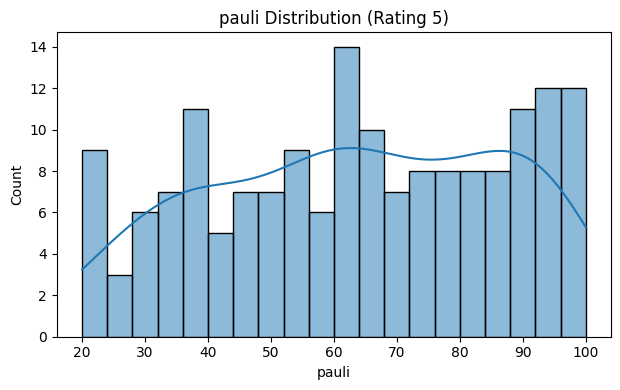

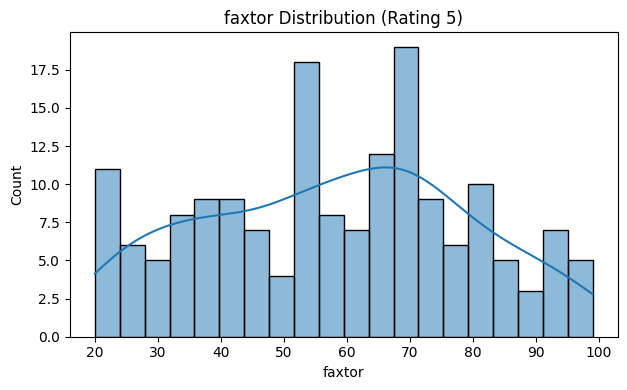

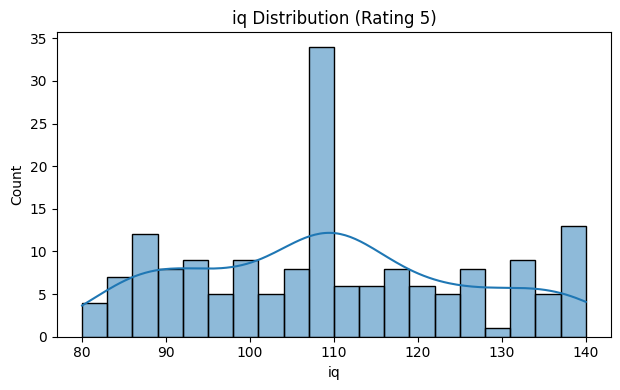

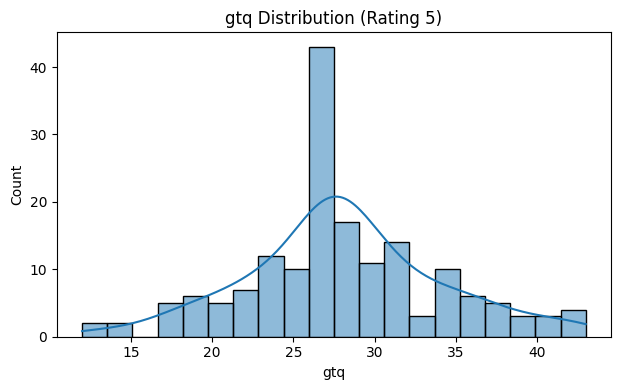

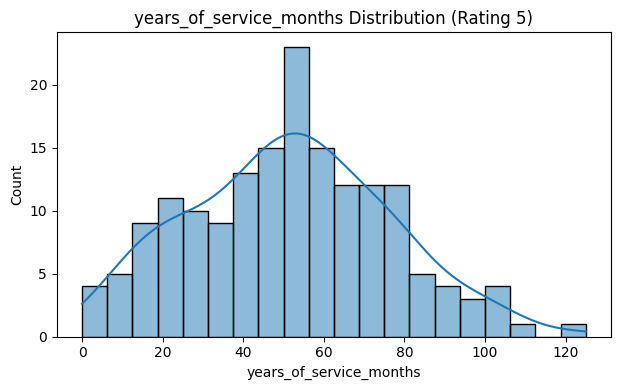

In [54]:
num_vis(rating5_df, num_cols)

> Employees rated 5 show distinct patterns across several quantitative factors. Psychometric measures indicate balanced and stable traits, with Pauli scores peaking around 20 and 60–70, Faxtor scores between 50 and 70, and IQ concentrated near 110. GTQ and years of service peak around the median and follow roughly normal distributions, suggesting that overall balance and moderate experience support top performance.

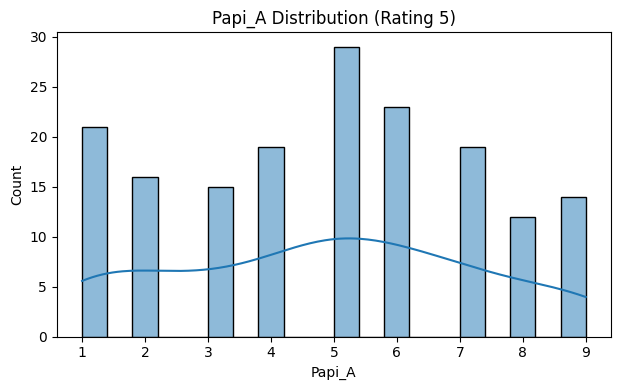

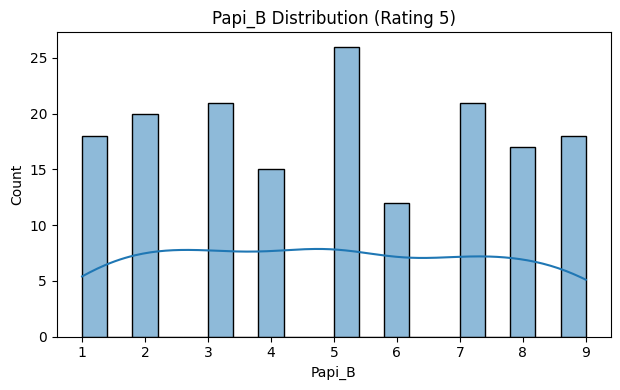

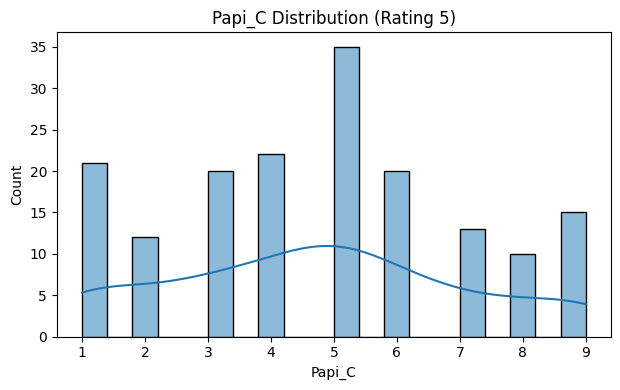

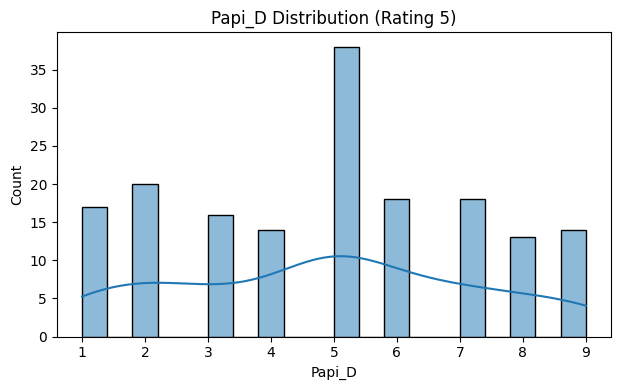

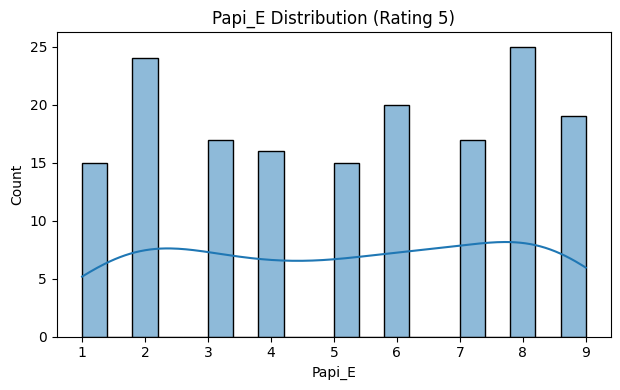

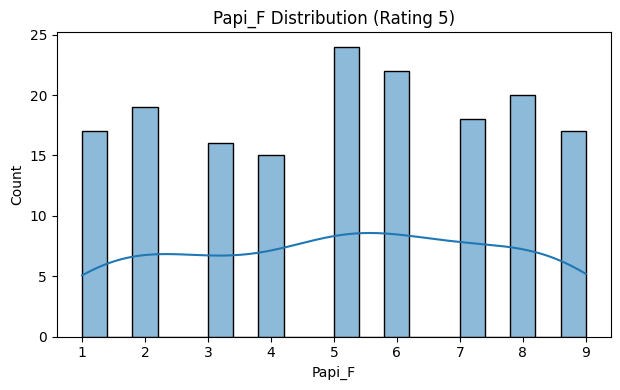

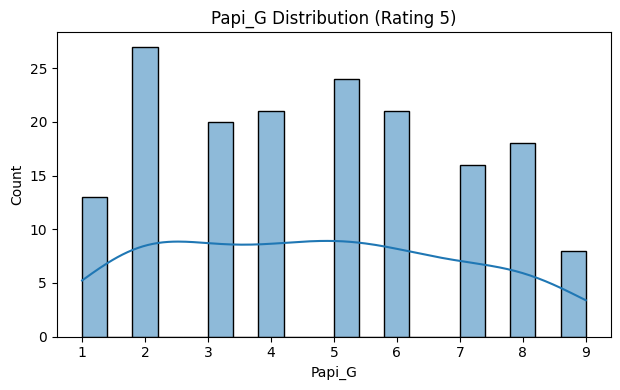

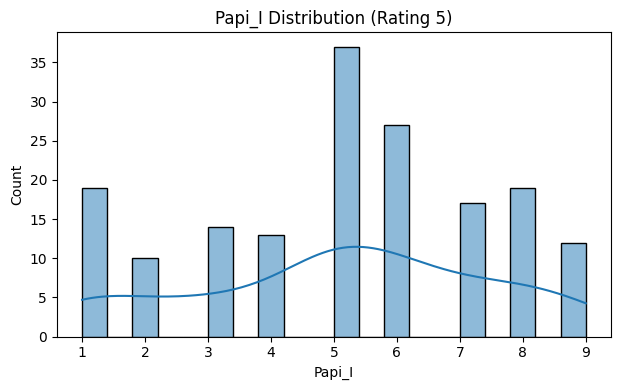

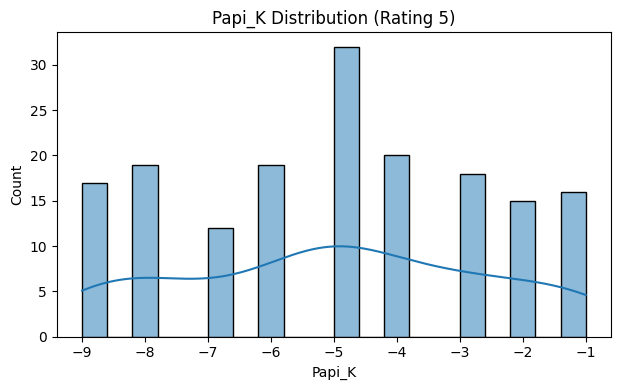

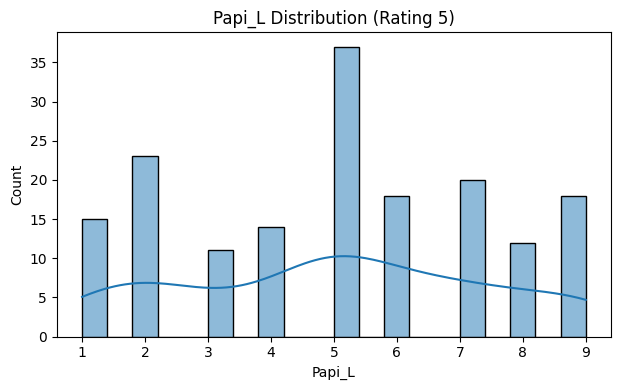

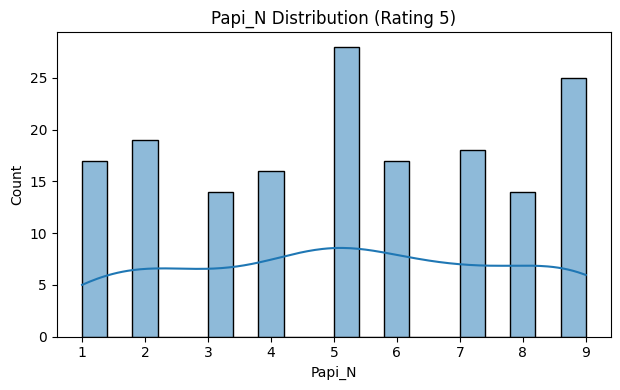

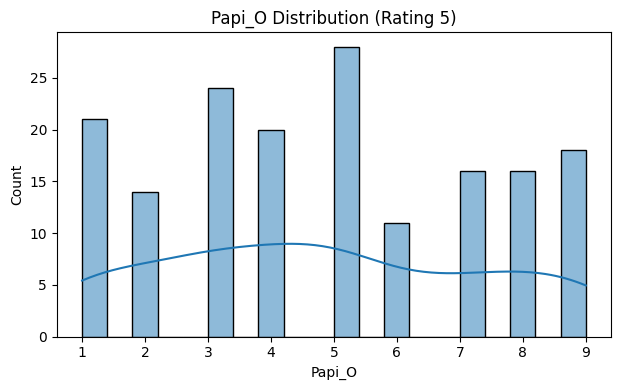

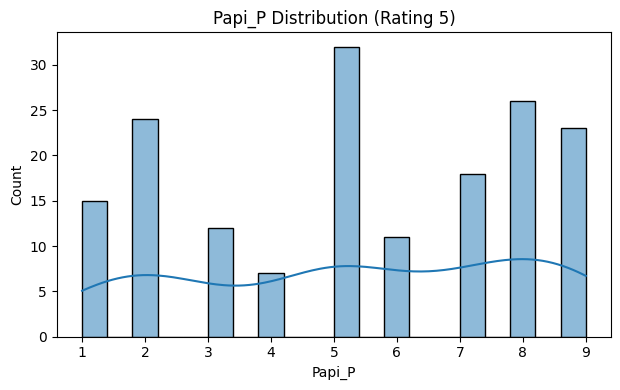

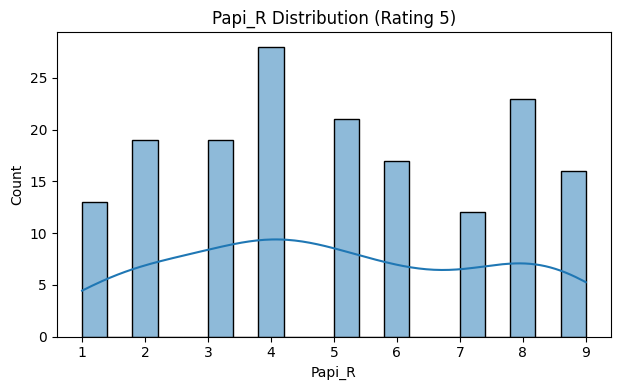

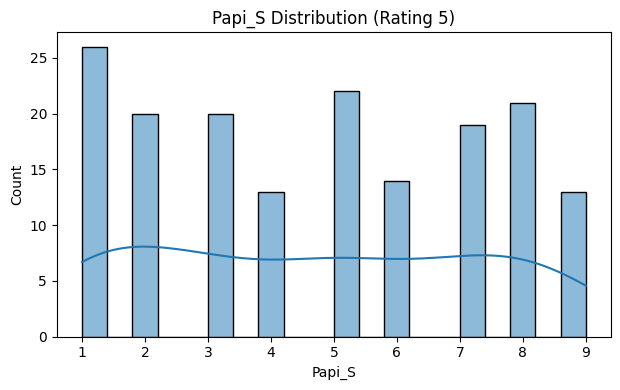

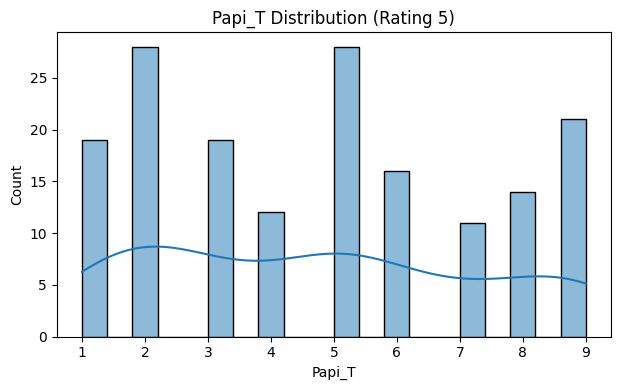

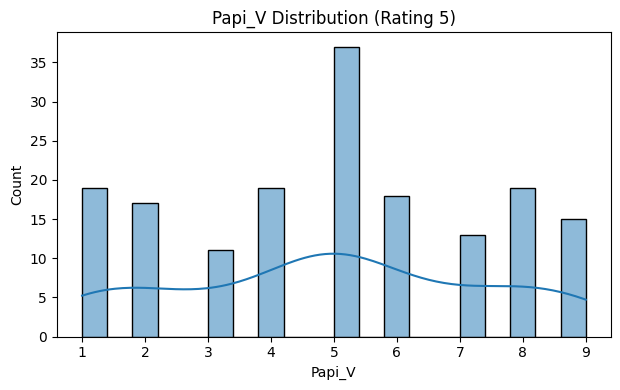

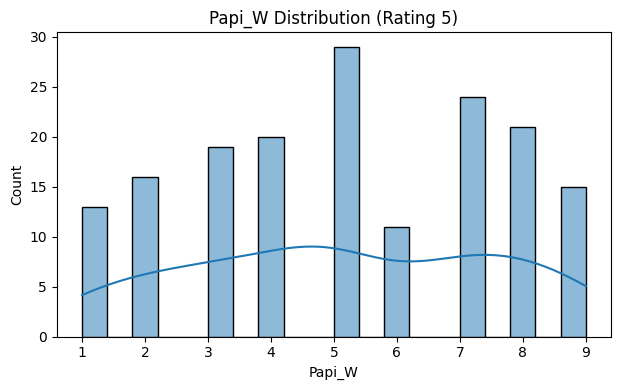

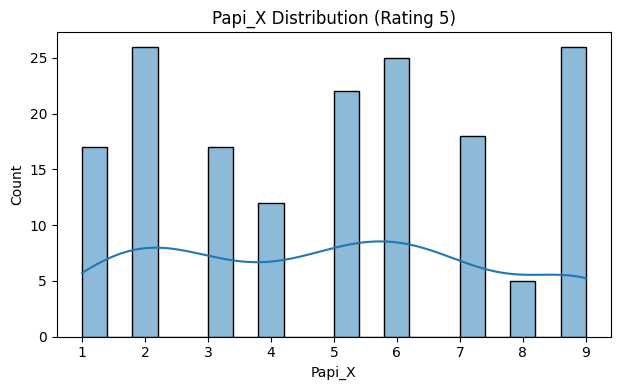

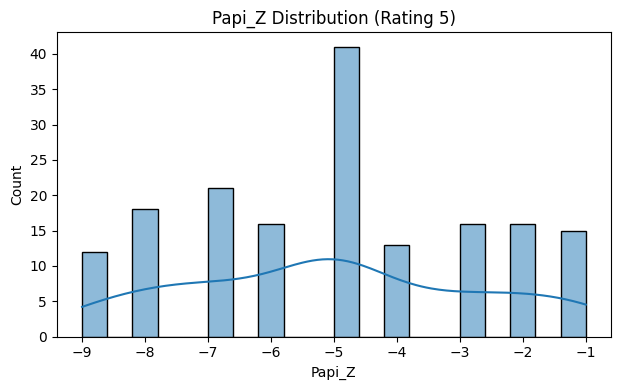

In [55]:
num_vis(rating5_df, num_cols_papi)

> The analysis of PAPI score distributions for employees rated 5 shows that scores cluster across the 20 scales from A to Z. Peaks appear randomly across different scales, with no consistent pattern or extreme skew. Some scales exhibit relatively high scores, others moderate or low, but no single scale dominates the overall profile. These results indicate a generally balanced distribution with varied strengths across the scales.

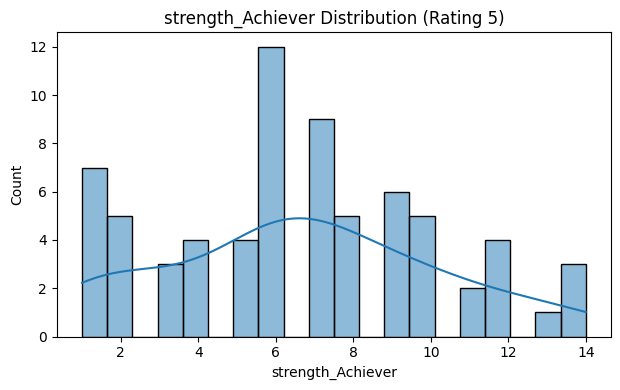

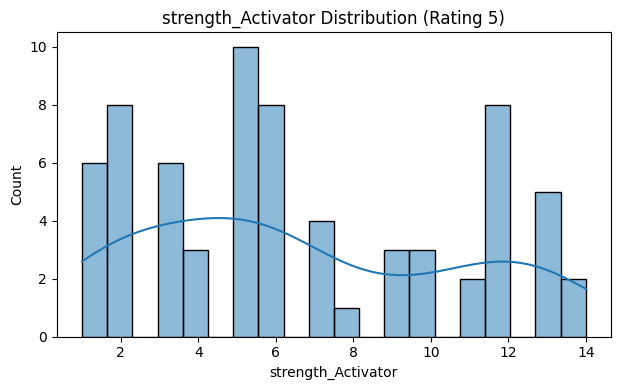

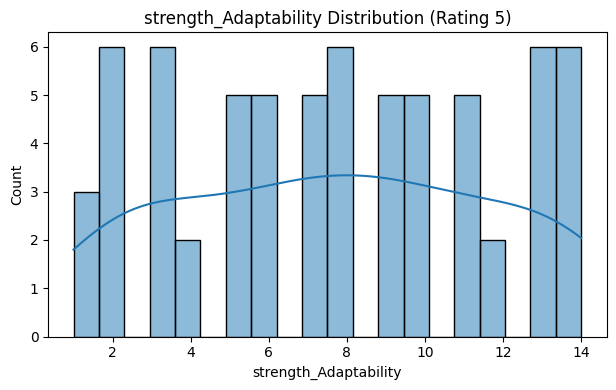

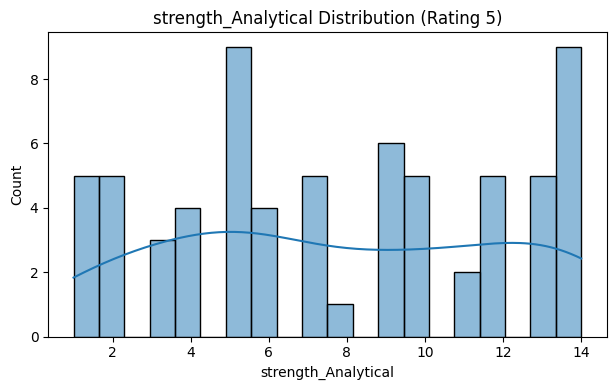

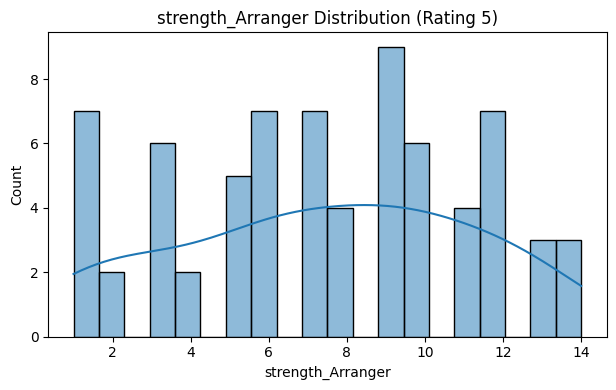

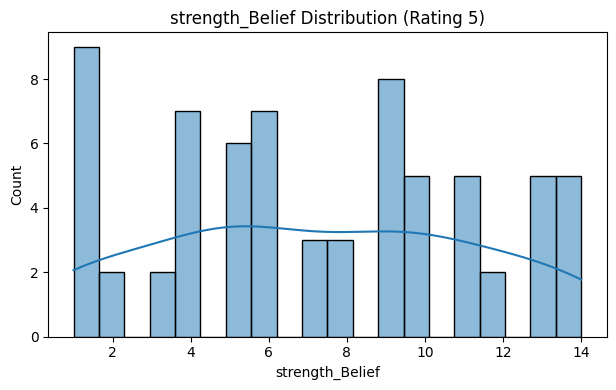

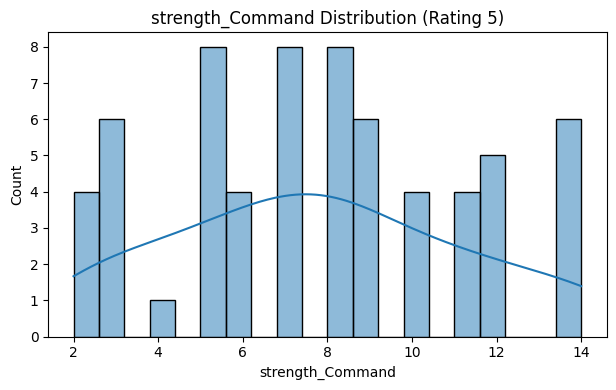

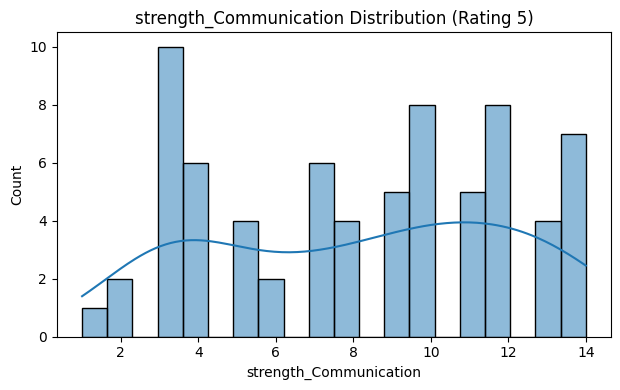

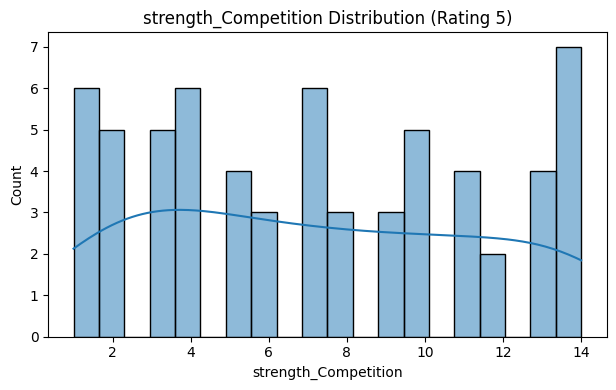

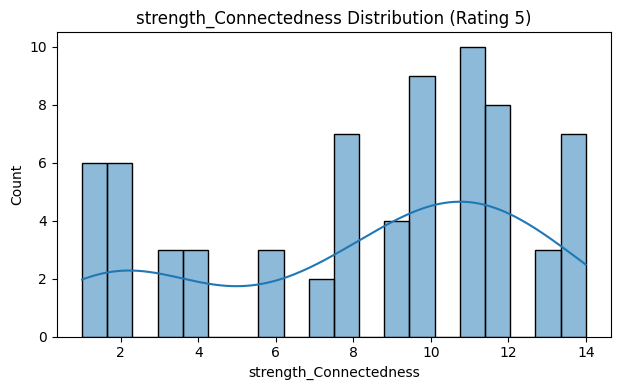

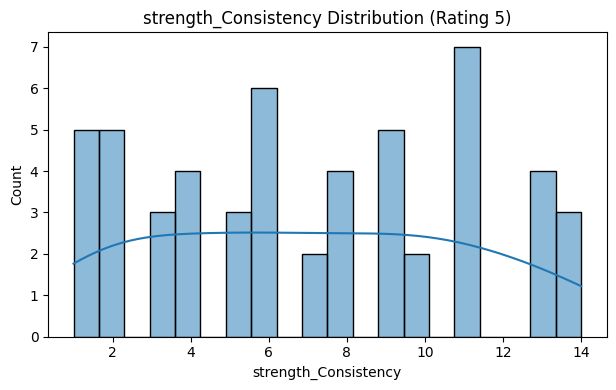

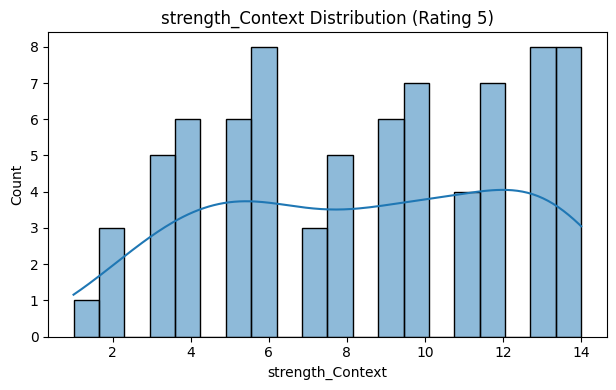

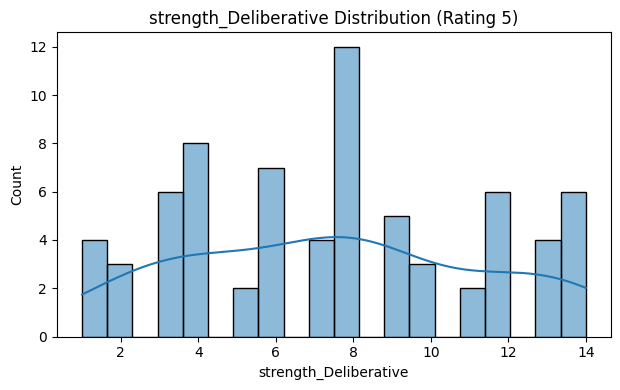

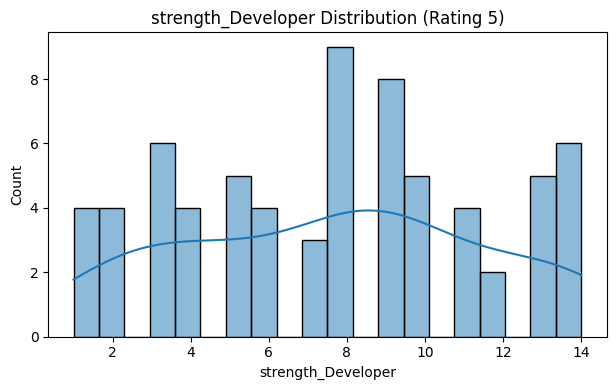

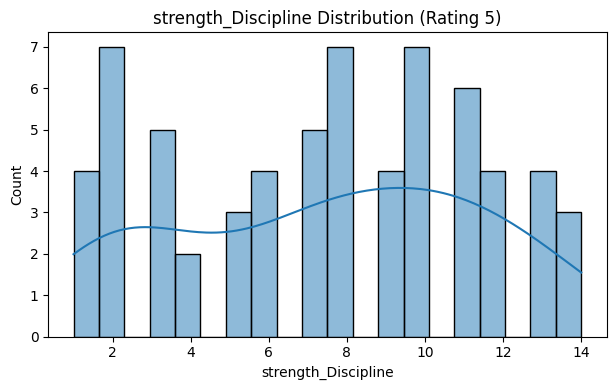

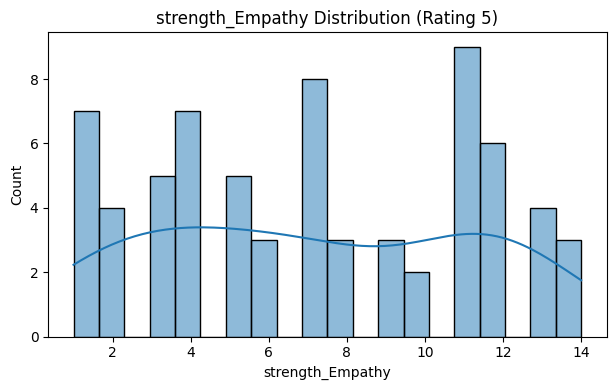

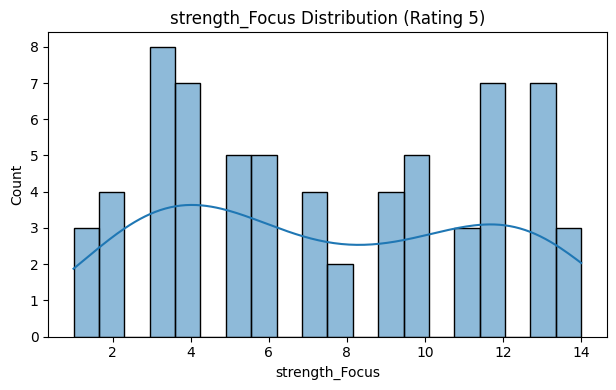

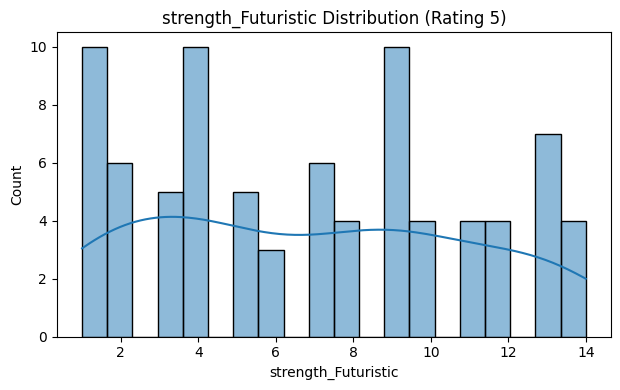

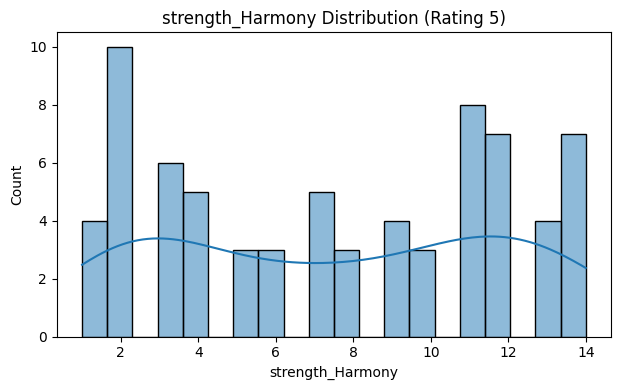

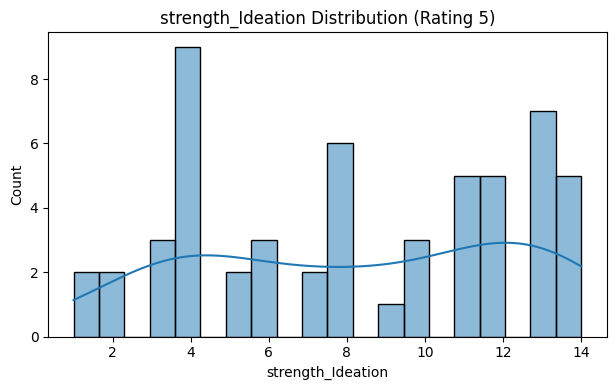

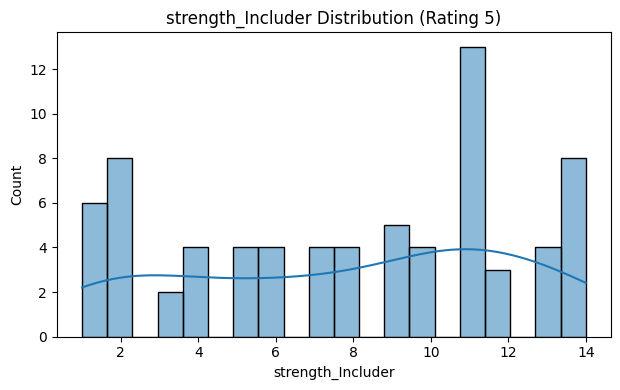

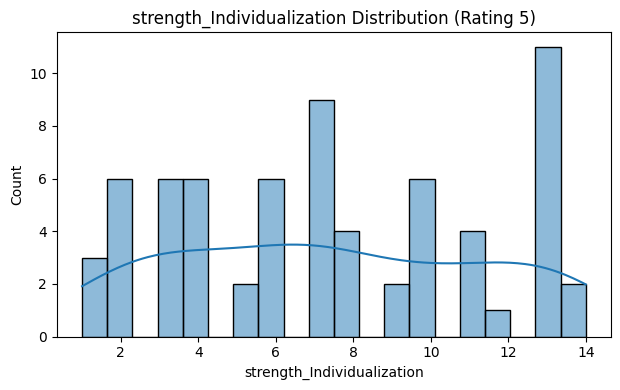

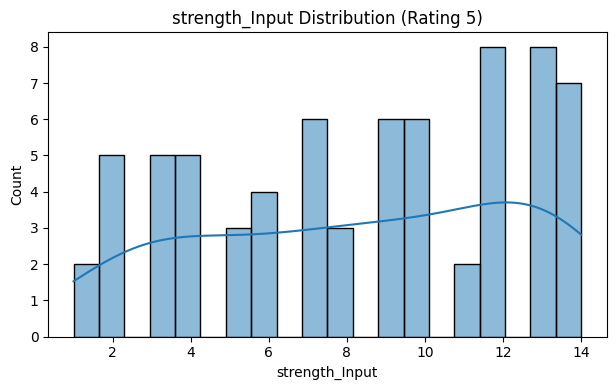

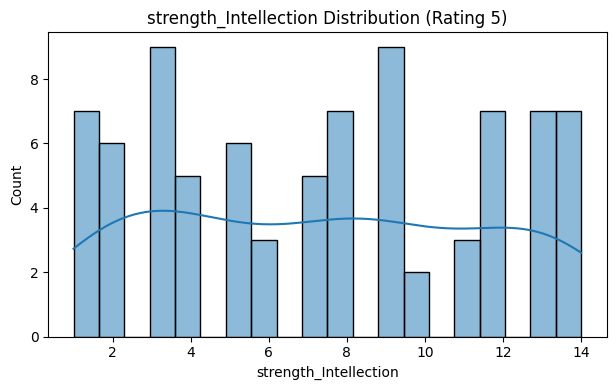

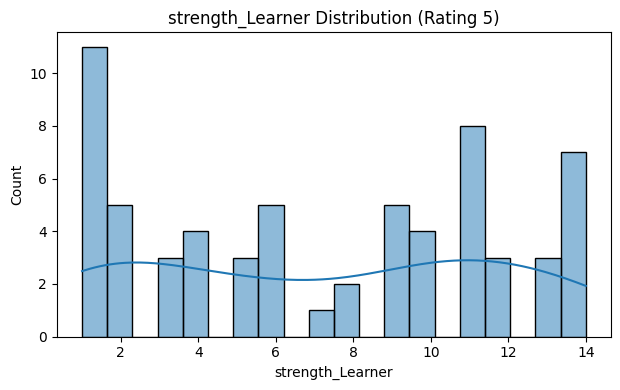

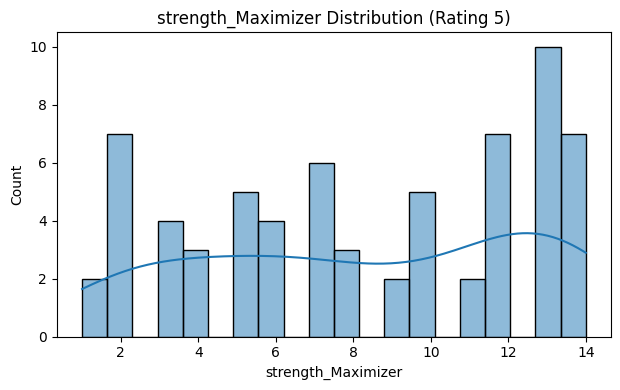

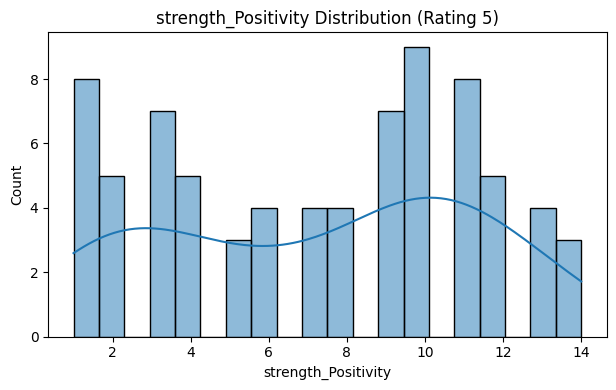

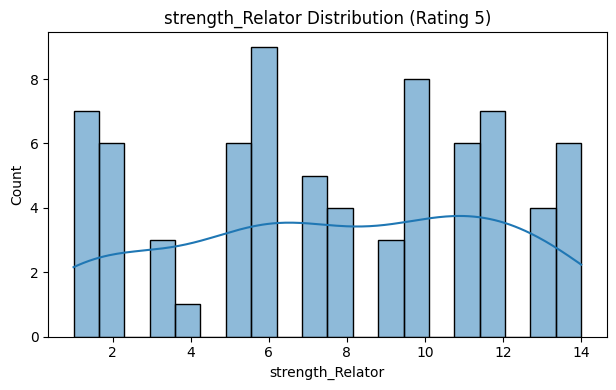

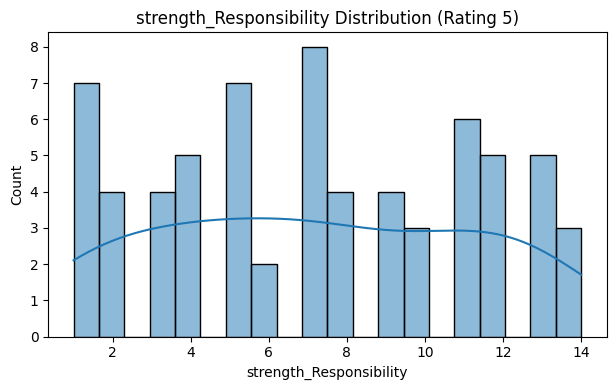

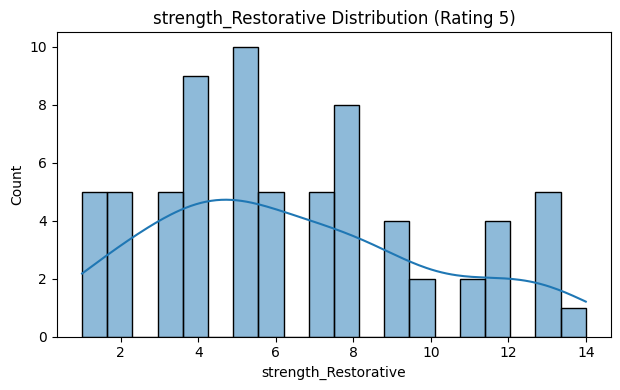

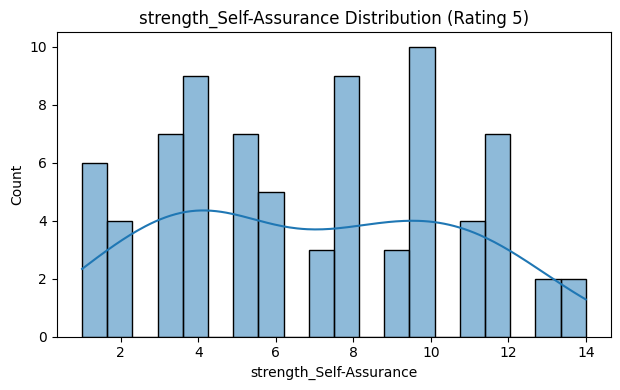

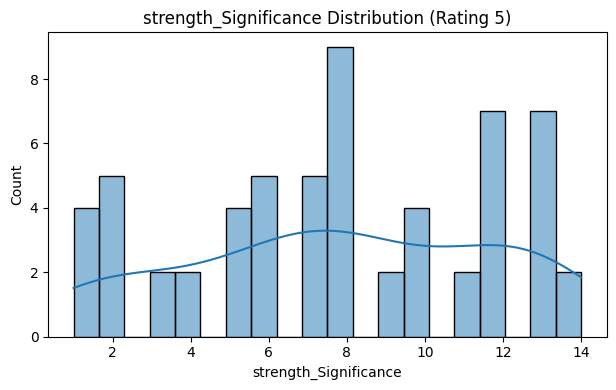

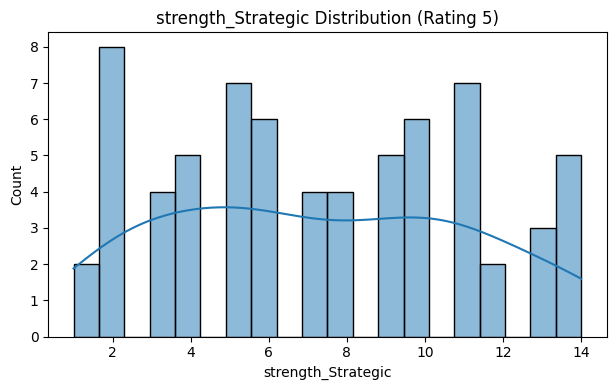

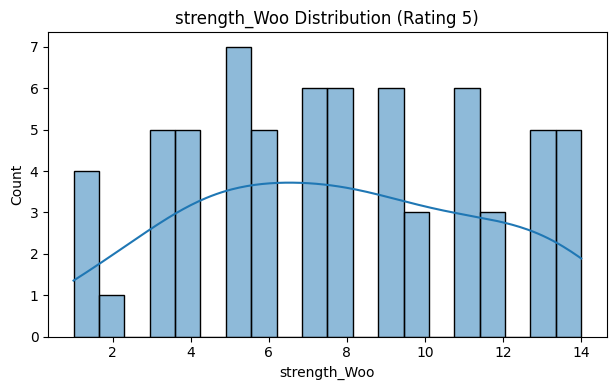

In [56]:
num_vis(rating5_df, num_cols_strength)

> The histogram plots for the strengths ranks demonstrate that employees rated 5 frequently show high concentrations in the top ranks. Achiever peaks at ranks 5 and 6 with the highest counts. Adaptability, Focus, and Learner show high counts across several ranks. Analytical peaks at ranks 5 and 14. Communication peaks at rank 3. Competition is fairly even across ranks, while Consistency is also fairly even but has many counts. Overall, the distributions reveal that top-rated employees display varied strengths with notable concentrations depending on the specific theme.

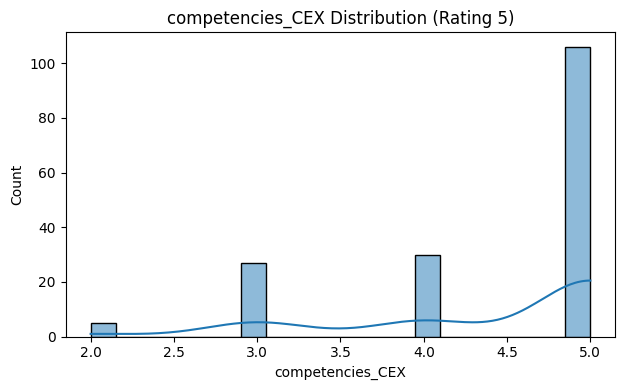

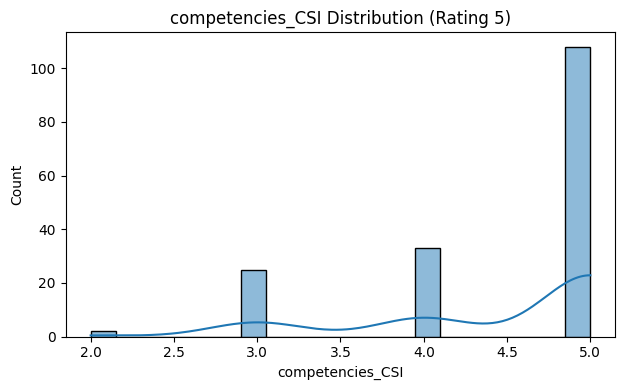

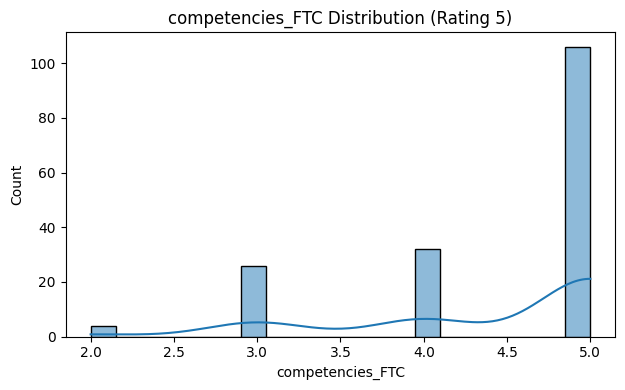

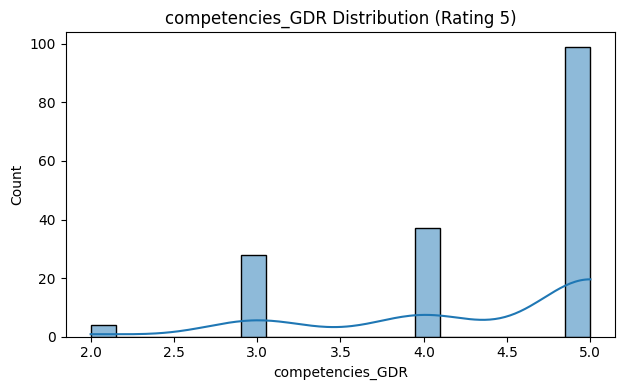

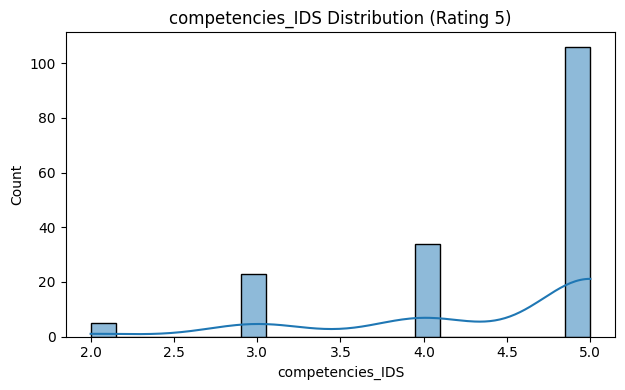

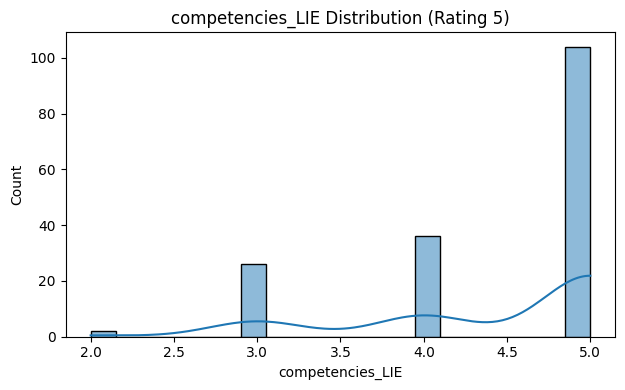

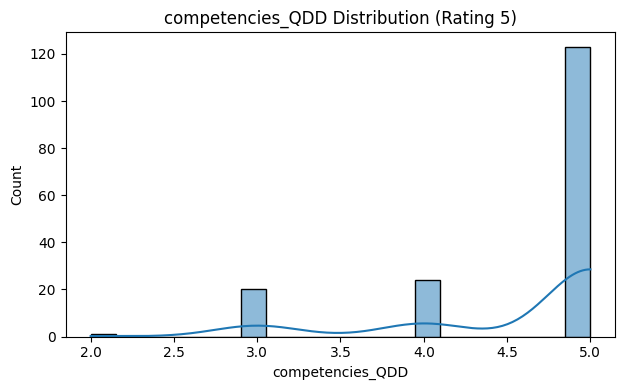

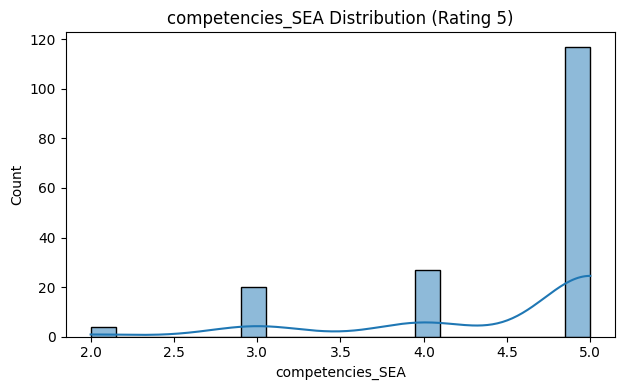

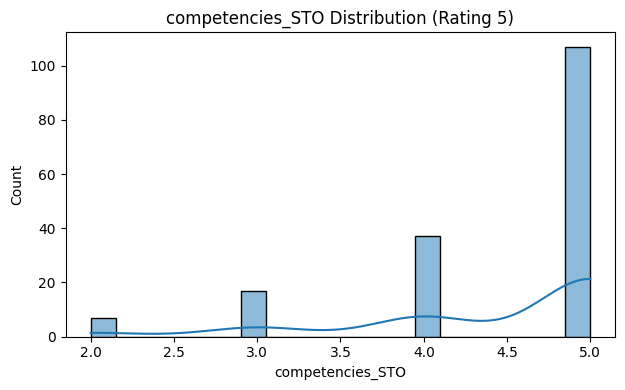

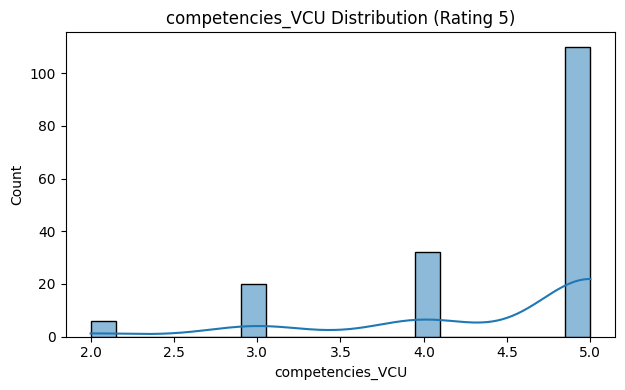

In [57]:
num_vis(rating5_df, num_cols_competencies)

> The distributions of the competency pillars for top-rated employees show clear peaks at a score of 5. In particular, CEX, CSI, FTC, GDR, IDS, LIE, QDD, SEA, STO, and VCU all reach their highest counts at this score, indicating consistent top performance across these pillars.

In [58]:
def ctg_vis(df, cols_name, isOHE=False, label=''):
  if isOHE:
    counts = df[cols_name].sum().sort_values(ascending=False)
    plt.figure(figsize=(8, max(4, 0.3*len(cols_name))))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'{label} Distribution (Rating 5)')
    plt.xlabel('Count')
    plt.ylabel(label)
    plt.xticks(rotation=90)
    plt.show()
  else:
    for col in cols_name:
      plt.figure(figsize=(8, max(4, 0.3*df[col].nunique())))
      sns.countplot(y=col, data=df, order=df[col].value_counts().index)
      plt.title(f'{col} Distribution (Rating 5)')
      plt.xlabel('Count')
      plt.ylabel(col)
      plt.show()

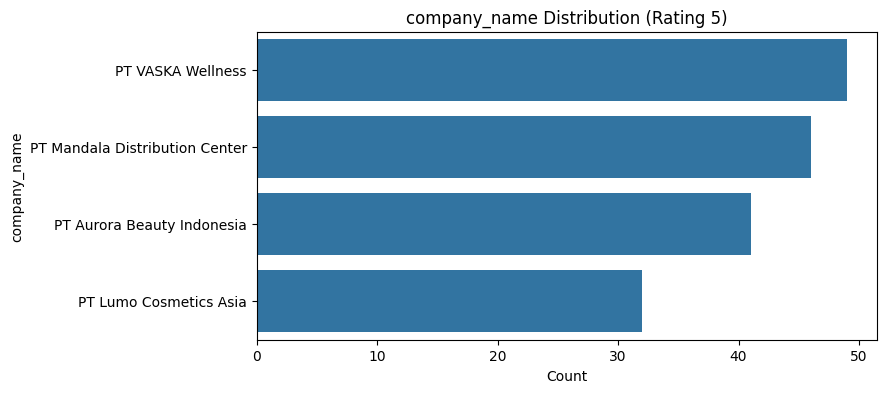

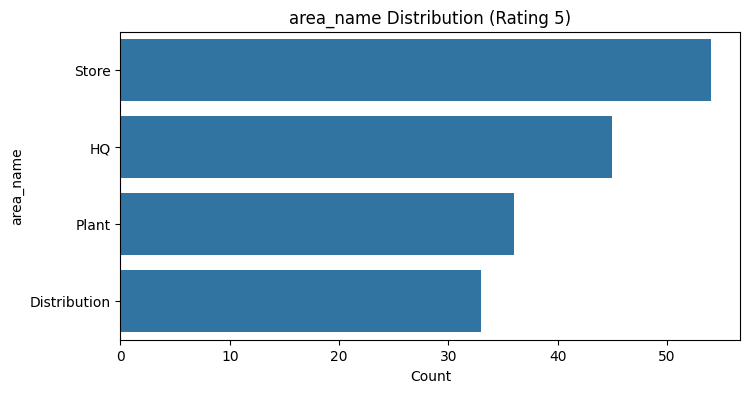

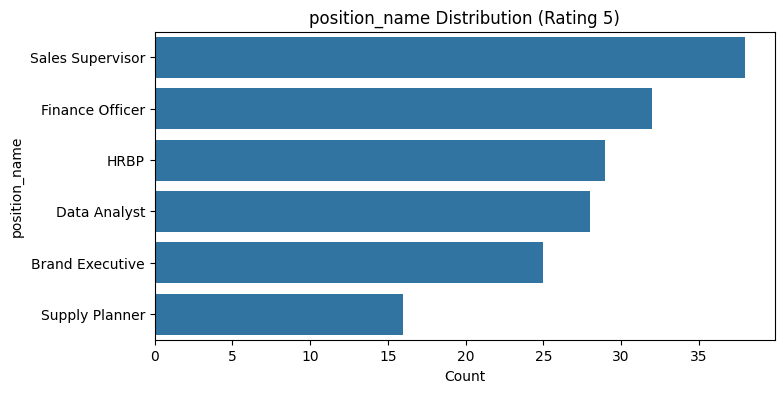

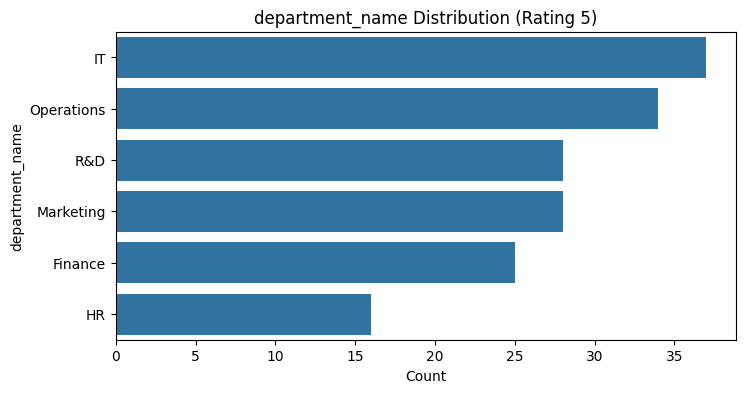

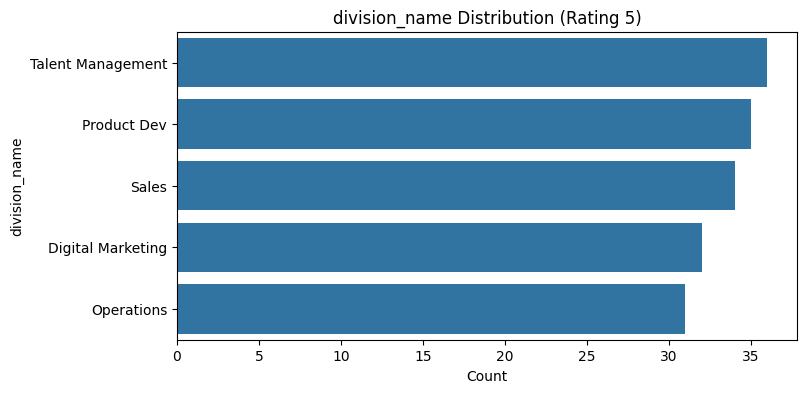

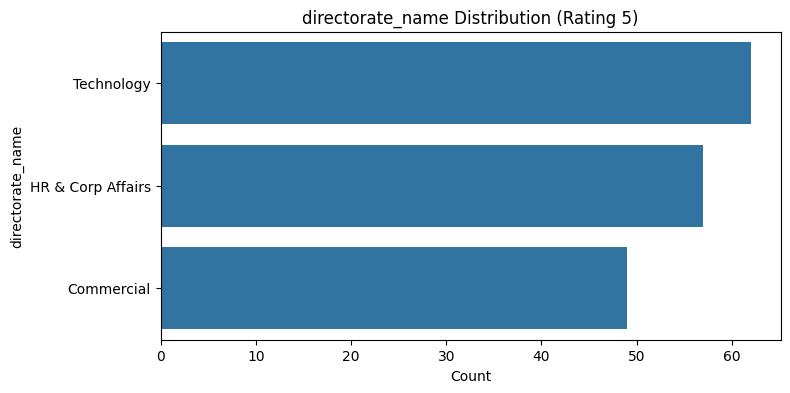

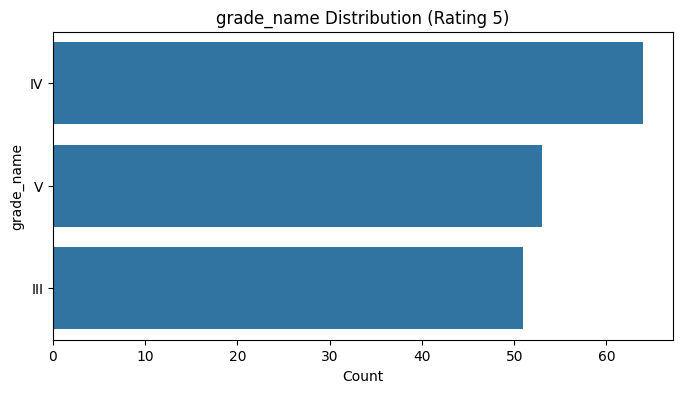

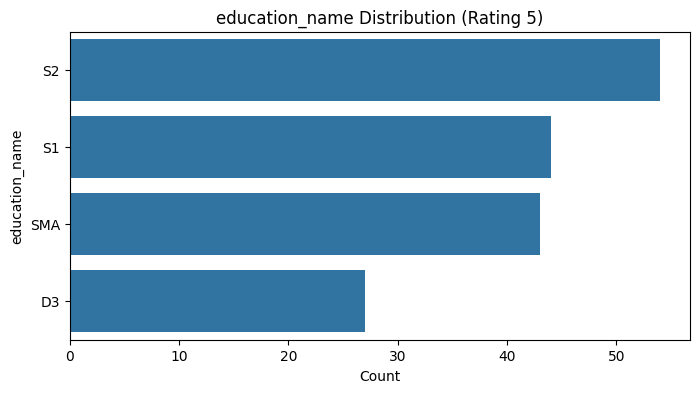

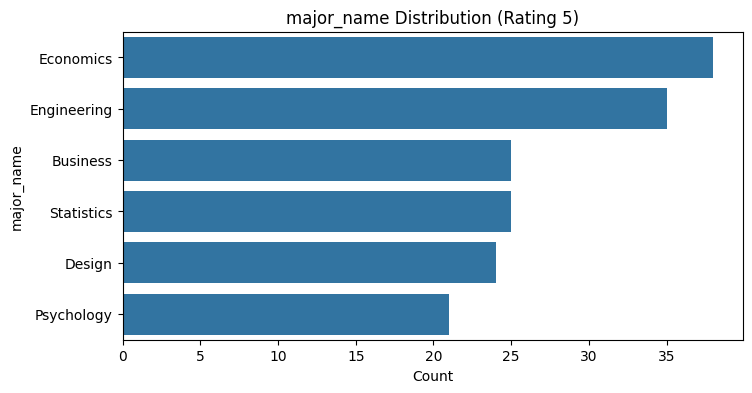

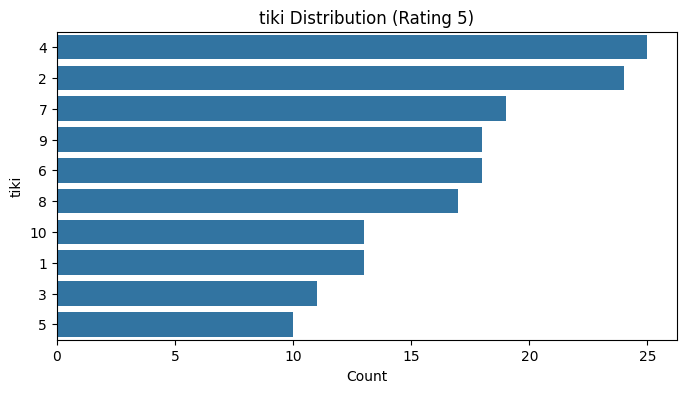

In [59]:
ctg_vis(rating5_df, ctg_cols)

> Employees achieving a rating of 5 tend to be more represented in certain contextual categories, although the overall distribution remains balanced without skew. Higher concentrations are observed among those working in Store roles, in Sales or Finance positions, within the IT and Operations departments, and among employees with a Master’s degree in Economics or Engineering.

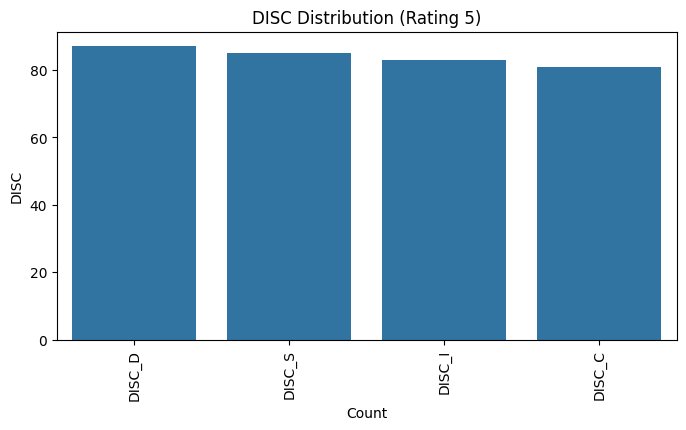

In [60]:
ctg_vis(rating5_df, ctg_cols_disc, True, 'DISC')

> The barplot frequencies of DISC types among employees rated 5 are generally balanced. Dominance (D) appears most frequently, while Conscientiousness (C) is the least frequent, but the differences across all types are small, indicating a relatively even distribution.

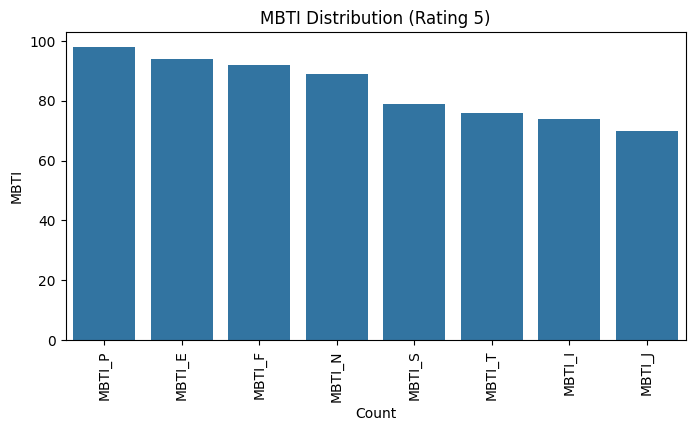

In [61]:
ctg_vis(rating5_df, ctg_cols_mbti, True, 'MBTI')

> The barplot of MBTI letters (E, I, S, N, T, F, J, P) shows that Perceiving (P) is the most common, followed by Extraversion (E), while Judging (J) is the least frequent. Despite these differences, the overall distribution of letters is fairly balanced.

> Employees rated 5 demonstrate consistently high performance across competencies, while distributions for other segments remain balanced and stable. Certain scores and traits show peaks, such as competency scores, but no single measure dominates, indicating that high performance arises from varied rather than uniform profiles.

> Contextual and demographic factors further support this performance, with higher representation in specific roles, departments, and among employees with advanced educational backgrounds. These patterns suggest that top performance results from a combination of balanced traits, diverse strengths, and supportive environments, rather than extreme specialization or singular personality types.

### Formula

> The dataset contains a substantial number of missing values, and the results presented here are based on imputed data. As a result, the findings may not fully reflect real-world outcomes and could differ slightly if complete data were available. Any formulas derived from this analysis should be interpreted with this limitation in mind.

> There are several ways to approach this analysis. Missing values were imputed prior to modeling, which introduces some uncertainty but allows the model to leverage all available information. Based on https://arxiv.org/abs/1603.02754, XGBoost is well-suited for this high-dimensional, structured data because it can handle numerous interacting features and still capture nuanced patterns in employee performance. This aligns with the observed finding that high performance emerges from varied strengths rather than uniform profiles

In [84]:
master_df['rating_bool'] = (master_df['performance_rating'] == 5).astype(int)

In [85]:
def compute_corr(df, cols_name):
  feature_cols = cols_name + ['rating_bool']
  corr = abs(df[feature_cols].corr())

  plt.figure(figsize=(12, 10))
  sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title("Feature Correlation Heatmap (absolute values)")
  plt.show()

In [86]:
def compute_xgboost(df, cols_name, n=5):
  X = df[cols_name].fillna(0)
  y = df['rating_bool']
  pos_weight = np.sqrt(len(y) - y.sum()) / y.sum()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.2,
    n_estimators=300,
    scale_pos_weight=pos_weight,
    subsample=0.8,
    colsample_bytree=0.8
  )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print('XGBoost Model Accuracy:', accuracy_score(y_test, y_pred))
  print('Classification Report:\n', classification_report(y_test, y_pred))
  importance = model.feature_importances_
  success_formula_df = pd.DataFrame({
      'feature': X.columns,
      'importance_weight': importance
  }).sort_values(by='importance_weight', ascending=False)

  print('\nSuccess Formula (Top Feature Importance Weights):')
  print(success_formula_df.head(n))

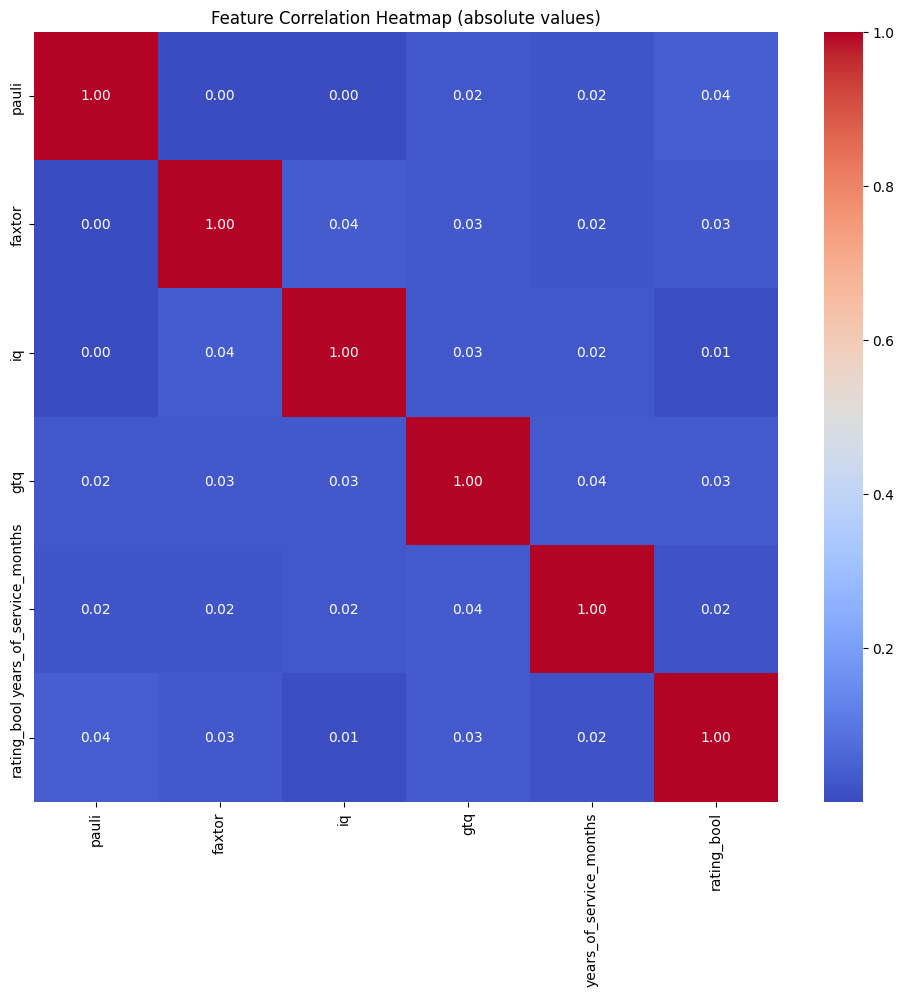

XGBoost Model Accuracy: 0.9129353233830846
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.95       368
           1       0.00      0.00      0.00        34

    accuracy                           0.91       402
   macro avg       0.46      0.50      0.48       402
weighted avg       0.84      0.91      0.87       402


Success Formula (Top Feature Importance Weights):
                   feature  importance_weight
2                       iq           0.205278
1                   faxtor           0.202048
0                    pauli           0.201223
4  years_of_service_months           0.199498
3                      gtq           0.191953


In [87]:
compute_corr(master_df, num_cols)
compute_xgboost(master_df, num_cols)

> The XGBoost model achieved an overall accuracy of 91.3%, indicating strong performance in predicting the dominant class. However, the classification report reveals that the model struggles with the minority class (label 1), achieving 0% precision and recall, highlighting a severe class imbalance issue. Analysis of feature importance in the success formula shows that IQ (0.205), Faxtor (0.202), and Pauli (0.201) are the top predictors, suggesting that cognitive ability, initial performance, and experience are the most influential factors in predicting outcomes.

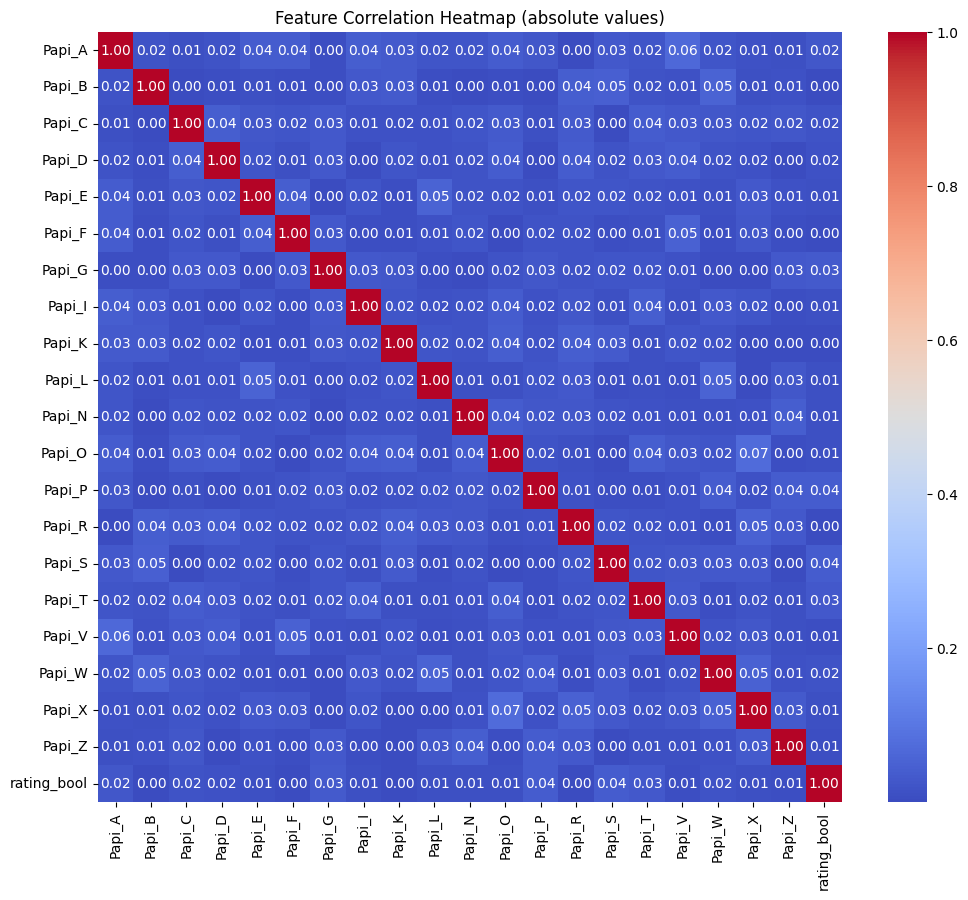

XGBoost Model Accuracy: 0.9154228855721394
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       368
           1       0.00      0.00      0.00        34

    accuracy                           0.92       402
   macro avg       0.46      0.50      0.48       402
weighted avg       0.84      0.92      0.88       402


Success Formula (Top Feature Importance Weights):
   feature  importance_weight
0   Papi_A           0.055125
14  Papi_S           0.054682
5   Papi_F           0.054588
19  Papi_Z           0.054291
3   Papi_D           0.053908


c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [88]:
compute_corr(master_df, num_cols_papi)
compute_xgboost(master_df, num_cols_papi)

> The XGBoost model achieved an overall accuracy of 91.5%, performing very well on the majority class but completely failing to predict the minority class (0% precision and recall), indicating a significant class imbalance. The top features contributing to the model's predictions were Papi_A (0.055), Papi_S (0.055), and Papi_F (0.055) showing a relatively even distribution of importance among them.

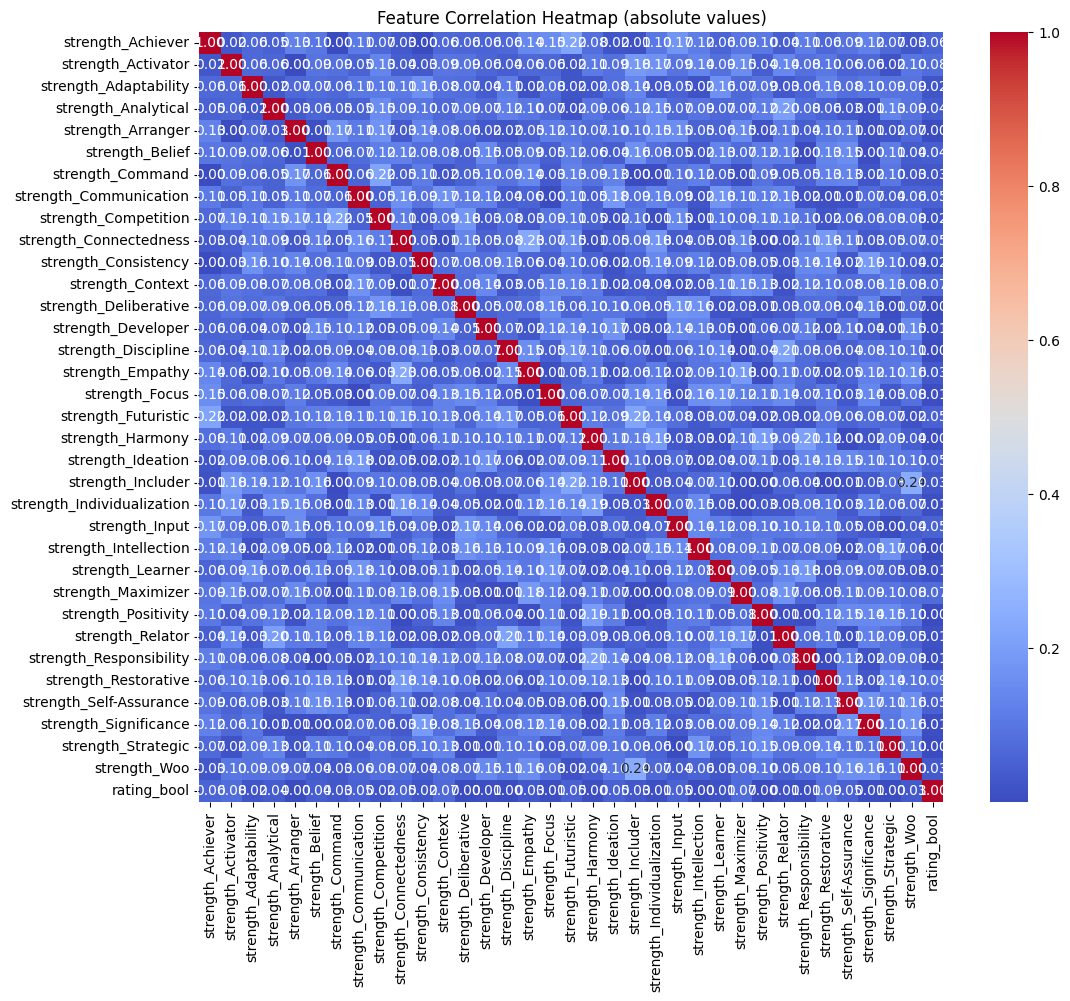

XGBoost Model Accuracy: 0.9154228855721394
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       368
           1       0.00      0.00      0.00        34

    accuracy                           0.92       402
   macro avg       0.46      0.50      0.48       402
weighted avg       0.84      0.92      0.88       402


Success Formula (Top Feature Importance Weights):
                    feature  importance_weight
19        strength_Ideation           0.042820
29     strength_Restorative           0.036948
25       strength_Maximizer           0.034487
1        strength_Activator           0.034475
28  strength_Responsibility           0.031494


c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [89]:
compute_corr(master_df, num_cols_strength)
compute_xgboost(master_df, num_cols_strength)

> The XGBoost model achieved an overall accuracy of 91.5%, performing very well on the majority class but completely failing to predict the minority class (0% precision and recall), highlighting a significant class imbalance. The top features driving predictions were strength_Ideation (0.043), strength_Restorative (0.037), and strength_Maximizer (0.034) showing a relatively balanced contribution among them.

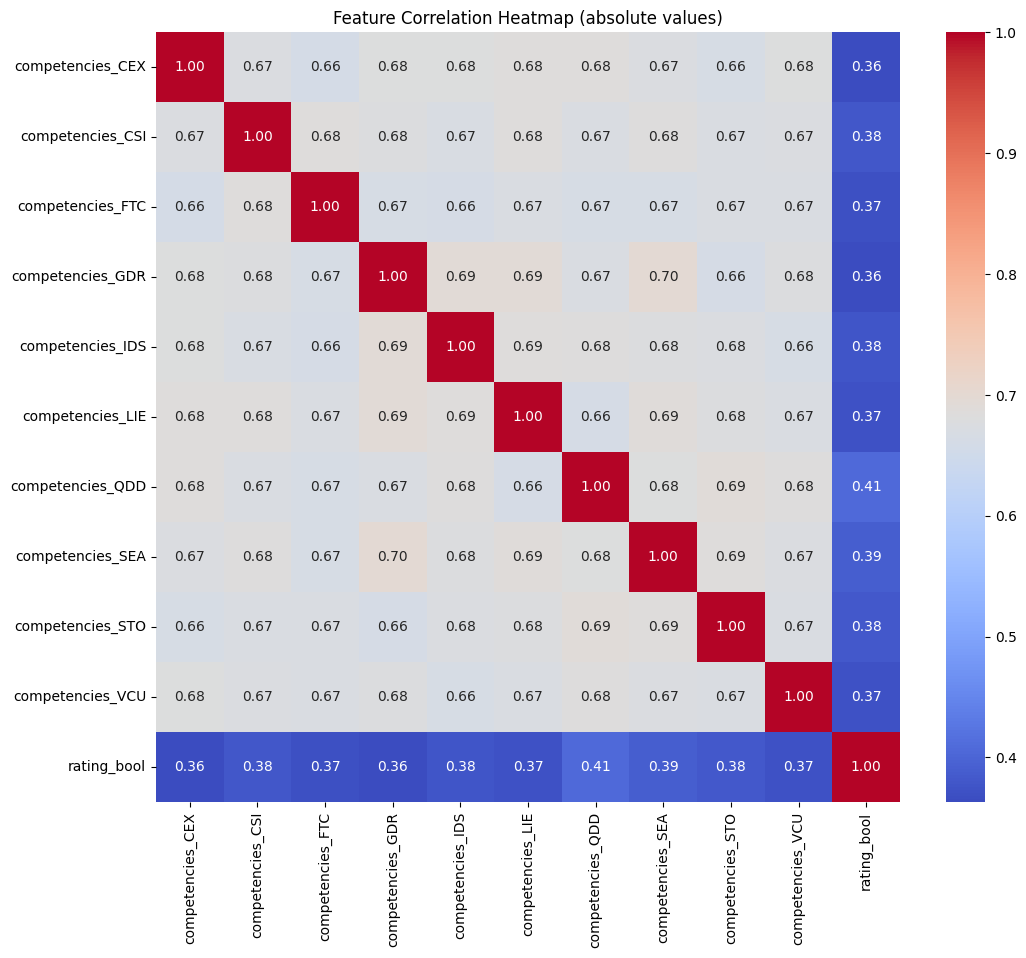

XGBoost Model Accuracy: 0.9626865671641791
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       368
           1       0.91      0.62      0.74        34

    accuracy                           0.96       402
   macro avg       0.94      0.81      0.86       402
weighted avg       0.96      0.96      0.96       402


Success Formula (Top Feature Importance Weights):
            feature  importance_weight
6  competencies_QDD           0.145275
7  competencies_SEA           0.137990
9  competencies_VCU           0.129786
8  competencies_STO           0.119490
4  competencies_IDS           0.106847


In [90]:
compute_corr(master_df, num_cols_competencies)
compute_xgboost(master_df, num_cols_competencies)

> The XGBoost model achieved an overall accuracy of 96.3%, showing strong predictive performance across both classes. The model performs exceptionally well on the majority class (0) with a precision of 97% and recall of 99%, and demonstrates much-improved performance on the minority class (1) with a precision of 91% and recall of 62%, reflecting a better balance than previous iterations. The top features driving predictions are competencies_QDD (0.145), competencies_SEA (0.138), competencies_VCU (0.130), competencies_STO (0.119), and competencies_IDS (0.107), indicating that specific competency measures strongly influence the model’s success predictions.

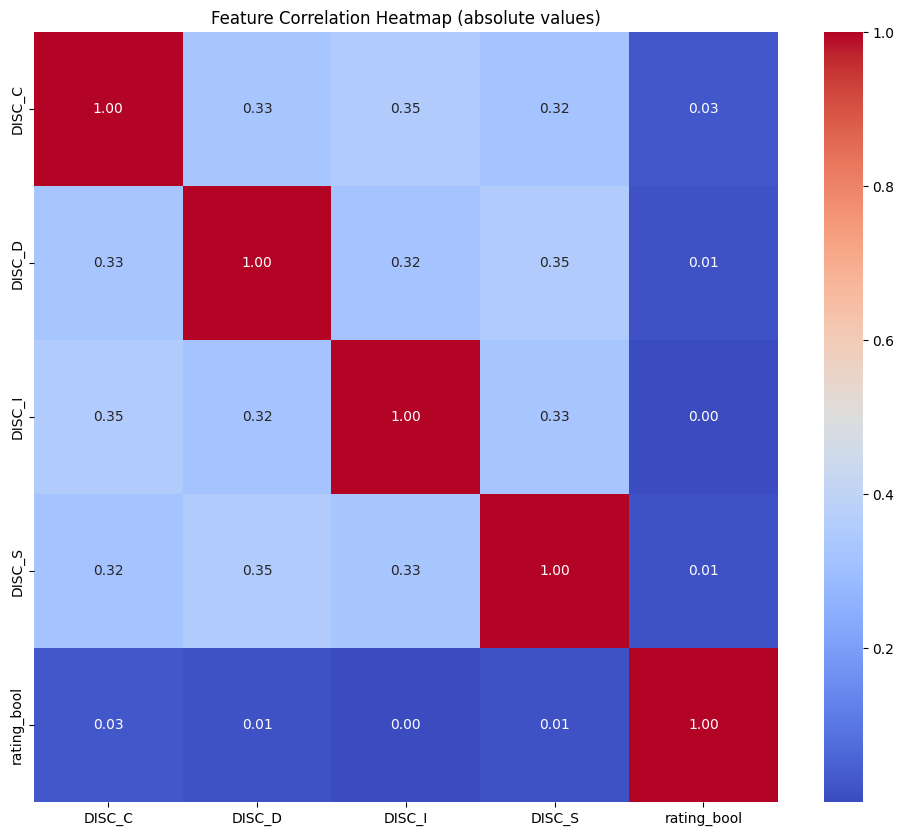

XGBoost Model Accuracy: 0.9154228855721394
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       368
           1       0.00      0.00      0.00        34

    accuracy                           0.92       402
   macro avg       0.46      0.50      0.48       402
weighted avg       0.84      0.92      0.88       402


Success Formula (Top Feature Importance Weights):
  feature  importance_weight
3  DISC_S           0.276720
1  DISC_D           0.267765
2  DISC_I           0.234110
0  DISC_C           0.221405


c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [91]:
compute_corr(master_df, ctg_cols_disc)
compute_xgboost(master_df, ctg_cols_disc)

> The XGBoost model achieved an overall accuracy of 91.5%, performing very well on the majority class (0) with a recall of 100%, but failing to predict the minority class (1), which resulted in 0% precision and recall and highlights a class imbalance issue. The top features driving the model’s predictions were DISC_S (0.277), DISC_D (0.268), DISC_I (0.234), and DISC_C (0.221), indicating that the model relies heavily on DISC personality dimensions.

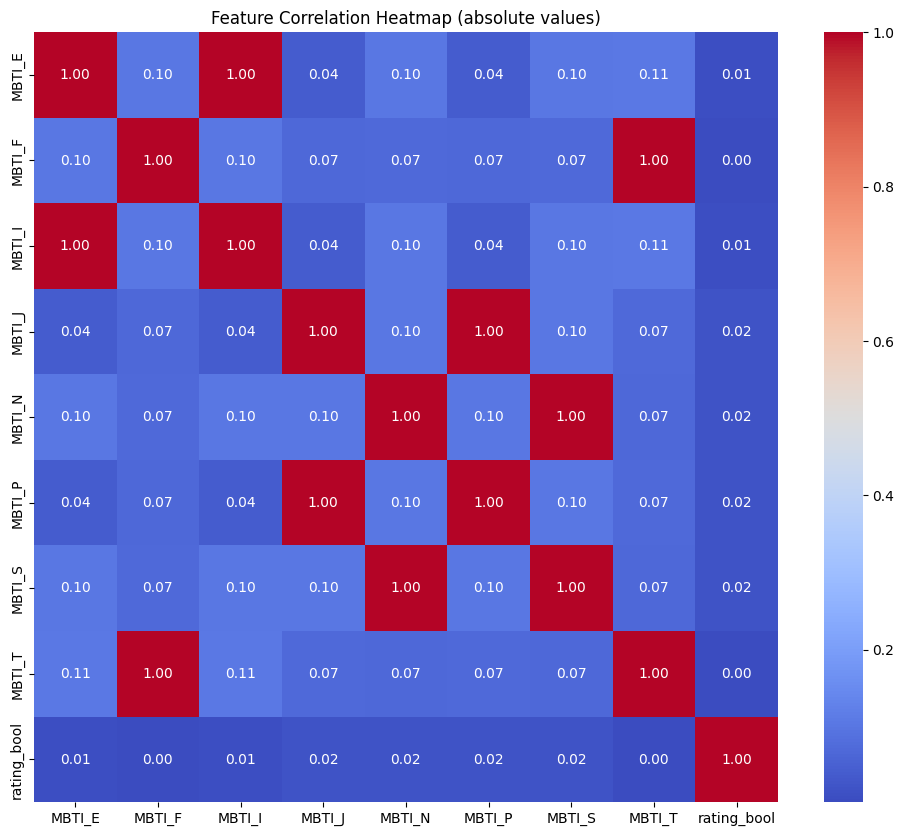

XGBoost Model Accuracy: 0.9154228855721394
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       368
           1       0.00      0.00      0.00        34

    accuracy                           0.92       402
   macro avg       0.46      0.50      0.48       402
weighted avg       0.84      0.92      0.88       402


Success Formula (Top Feature Importance Weights):
  feature  importance_weight
7  MBTI_T           0.147044
0  MBTI_E           0.136879
2  MBTI_I           0.125849
3  MBTI_J           0.124848
6  MBTI_S           0.121132


c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\HW\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [92]:
compute_corr(master_df, ctg_cols_mbti)
compute_xgboost(master_df, ctg_cols_mbti)

> The XGBoost model achieved an overall accuracy of 91.5%, performing very well on the majority class (0) with a recall of 100%, but failing to predict the minority class (1), resulting in 0% precision and recall and highlighting a significant class imbalance. The top features influencing predictions were MBTI_T (0.147), MBTI_E (0.137), and MBTI_I (0.126) showing that MBTI personality dimensions strongly drive the model’s decisions.

- Cognitive / Performance / Experience: IQ, Faxtor, Pauli
- PAPI Features: Papi_A, Papi_S, Papi_F
- Strength / Gallup Strengths: strength_Ideation
- Competency Features: competencies_QDD, competencies_SEA, competencies_VCU, competencies_STO, competencies_IDS
- DISC Personality Features: DISC_S. DISC_D
- MBTI Personality Features: MBTI_T

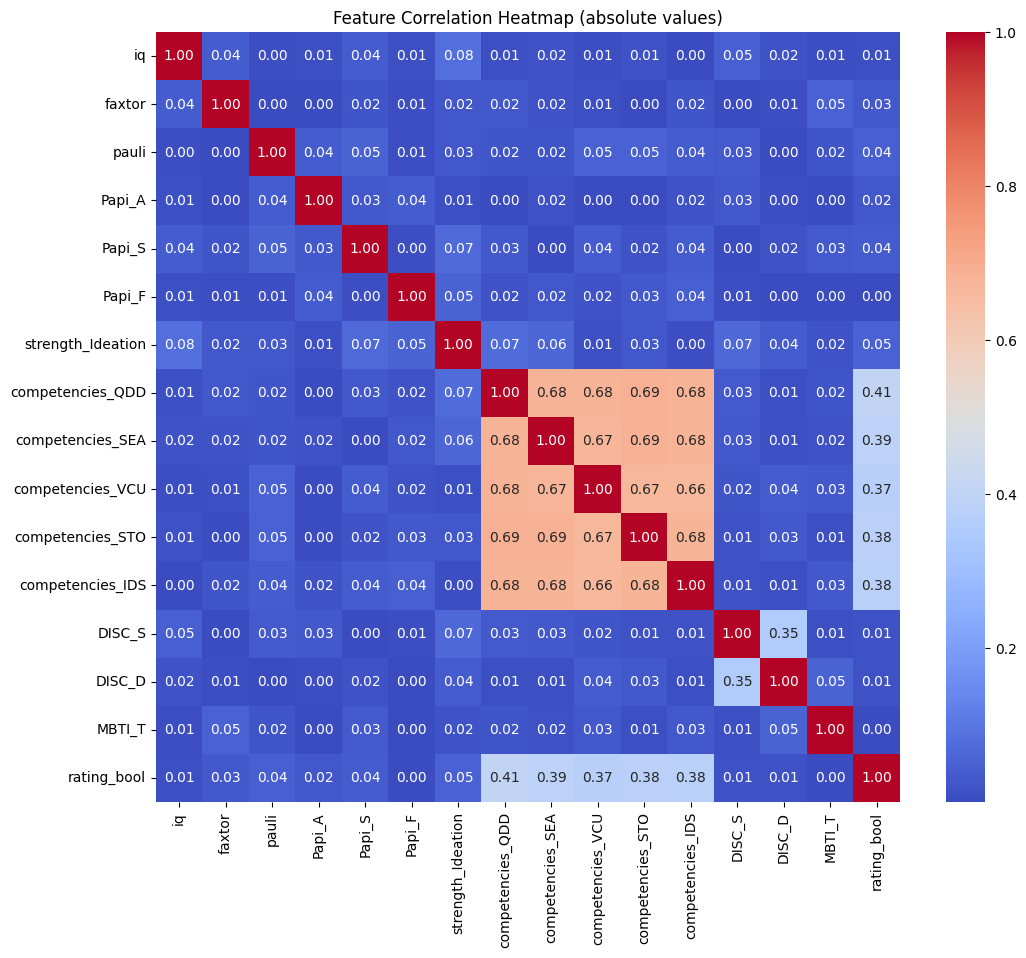

XGBoost Model Accuracy: 0.945273631840796
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       368
           1       0.83      0.44      0.58        34

    accuracy                           0.95       402
   macro avg       0.89      0.72      0.77       402
weighted avg       0.94      0.95      0.94       402


Success Formula (Top Feature Importance Weights):
              feature  importance_weight
7    competencies_QDD           0.168140
8    competencies_SEA           0.149106
11   competencies_IDS           0.132537
10   competencies_STO           0.125195
9    competencies_VCU           0.093856
13             DISC_D           0.039483
4              Papi_S           0.037889
3              Papi_A           0.037249
0                  iq           0.035099
6   strength_Ideation           0.034278


In [98]:
compute_corr(master_df, ['iq', 'faxtor', 'pauli', 'Papi_A', 'Papi_S', 'Papi_F', 'strength_Ideation', 'competencies_QDD', 'competencies_SEA', 'competencies_VCU', 'competencies_STO', 'competencies_IDS', 'DISC_S', 'DISC_D', 'MBTI_T'])
compute_xgboost(master_df, ['iq', 'faxtor', 'pauli', 'Papi_A', 'Papi_S', 'Papi_F', 'strength_Ideation', 'competencies_QDD', 'competencies_SEA', 'competencies_VCU', 'competencies_STO', 'competencies_IDS', 'DISC_S', 'DISC_D', 'MBTI_T'], 10)

> The analysis indicates that competencies are the primary drivers of employee performance. Although the correlation analysis showed generally low correlations across all features, the one-hot encoded competency columns displayed slightly stronger relationships compared to other variables with the target variable. This suggests that competencies contribute more meaningfully to performance than other factors, though data sparsity and imputed missing values may have reduced the apparent correlations for cognitive, personality, or demographic variables.

> To capture complex, nonlinear relationships beyond what correlation can reveal, an XGBoost model was applied, accounting for the dataset’s high dimensionality and class imbalance. While the model utilized all available features, the feature importance results reaffirmed that competencies dominate predictive power. The XGBoost model achieved 95% overall accuracy, performing very well on the majority class and moderately on the minority class.

> Overall, the findings suggest that while linear correlations are generally weak, competencies still emerge as the most consistent predictors of high performance. High performance appears to result from a balanced combination of traits, diverse competencies, and contextual support rather than extreme specialization or singular personality profiles. These insights were consolidated into a Success Formula, which integrates the weighted influence of multiple factors to provide a structured framework for identifying and developing high performers. The top predictors include competencies SEA, QDD, and VCU, followed by other competencies, DISC, PAPI, IQ, and strength measures, highlighting that performance is shaped by an interplay of skills, traits, and context.

| Talent Group Variable (TGV)                | Features Included                                         | Total Weight |
| ------------------------------------------ | --------------------------------------------------------- | -----------: |
| **Motivation & Drive**                     | competencies_QDD (0.168140), Papi_A (0.037249)            | **0.205389** |
| **Social Orientation & Collaboration**     | competencies_SEA (0.149106), Papi_S (0.037889)            | **0.186995** |
| **Creativity & Innovation Orientation**    | competencies_IDS (0.132537), strength_Ideation (0.034278) | **0.166815** |
| **Cognitive Complexity & Problem-Solving** | competencies_STO (0.125195), iq (0.035099)                | **0.160294** |
| **Cultural & Values Urgency**              | competencies_VCU (0.093856)                               | **0.093856** |
| **Leadership & Influence**                 | DISC_D (0.039483)                                         | **0.039483** |
